In [1]:
import os
import numpy as np

from utils.register_dataset import register_vrd_dataset
from config import parse_args, get_vrd_cfg
from utils.trainer import CustomTrainer

### [Optional] Training Visual Backbone Module

In [2]:
#Train Dataset
cfg = get_vrd_cfg(model_conf="faster_rcnn_R_50_FPN_3x.yaml")
register_vrd_dataset('vrd')
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [3]:
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

KeyboardInterrupt: 

In [21]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

detectron = build_model(cfg)

In [ ]:
b = detectron.backbone
b = None
detectron

In [ ]:
detectron.roi_heads.box_pooler

In [ ]:
from detectron2.modeling.poolers import ROIPooler
pooler = ROIPooler((7, 7), pooler_type='ROIAlignV2', scales=[1/4, 1/8, 1/16, 1/32], sampling_ratio=4)
pooler

In [ ]:
#Detections Output
import random
from utils.register_dataset import register_vrd_dataset
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

register_vrd_dataset('vrd')
detectron_dataset = DatasetCatalog.get("vrd_train")
vrd_metadata = MetadataCatalog.get("vrd_train")

In [ ]:
%matplotlib inline
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
for d in random.sample(detectron_dataset, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=vrd_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    img = vis.get_image()
    plt.figure(dpi=1200)
    plt.imshow(img)
    plt.show()

In [ ]:
import os
import json
from detectron2.structures import BoxMode
from config import ROOT_DIR, VRD_DATASET_PATH, VG200_DATASET_PATH

def load_dataset_annotations(dataset_name):
    """
        Load raw annotation dataset and convert it into standard detectron2 format
        Input:
            dataset_name: 'vrd/train' or 'vrd/val'
    """
    dataset_dicts = []
    set_name, set_type = dataset_name.split('/')
    if (set_name == 'vrd'):
        
        #VRD data path
        dataset_path = VRD_DATASET_PATH

        #load annotations file
        annotations = {}
        file_name = "new_annotations_{}.json".format(set_type)
        with open(os.path.join(dataset_path, file_name)) as annotations_file:
            annotations = json.load(annotations_file)
        
        #Map 'annotations' to the correct format
        img_file_dir = os.path.join(VRD_DATASET_PATH, '{}_images'.format(set_type))
        for key, val in annotations.items():
            record = {}

            #populating image fields
            img_file_path = os.path.join(img_file_dir, key)
            height, width = cv2.imread(img_file_path).shape[:2]

            record['file_name'] = img_file_path
            record['height'] = height
            record['width'] = width
            record['image_id'] = int(key.split('.')[0])

            #populating annotations from record
            objs = []
            visited = set()
            for anno in val:
                
                subj = anno['subject'] #ymin, ymax, xmin, xmax
                obj = anno['object']
                bbox_subj = subj['bbox']
                bbox_obj = obj['bbox']
                new_bbox_subj = [bbox_subj[2], bbox_subj[0], bbox_subj[3], bbox_subj[1]]
                new_bbox_obj = [bbox_obj[2], bbox_obj[0], bbox_obj[3], bbox_obj[1]]
                
                subj_dict = {
                    'bbox': new_bbox_subj,
                    'bbox_mode': BoxMode.XYXY_ABS,
                    'category_id': subj['category']
                }
                if (tuple(bbox_subj) not in visited):
                    objs.append(subj_dict)
                    visited.add(tuple(bbox_subj))

                obj_dict = {
                    'bbox': new_bbox_obj,
                    'bbox_mode': BoxMode.XYXY_ABS,
                    'category_id': obj['category'],
                }
                if (tuple(bbox_obj) not in visited):
                    objs.append(obj_dict)
                    visited.add(tuple(bbox_obj))

            record['annotations'] = objs
                         
            #add img to dataset dict
            dataset_dicts.append(record)
    
    return dataset_dicts
data = load_dataset_annotations('vrd/train')

### [Required] DataSet and DataLoader (Step 1)

In [2]:
from utils.dataset import VRDDataset

In [3]:
from utils.reldb import RelDB

In [4]:
#Extract ROI Features
"""
Relevant Links:
    https://towardsdatascience.com/faster-rcnn-object-detection-f865e5ed7fc4#:~:text=Faster%20RCNN%20is%20an%20object,SSD%20(%20Single%20Shot%20Detector).
"""
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import ImageList

from detectron2.modeling import build_backbone
from detectron2.modeling.poolers import ROIPooler
from transformers import BertTokenizer, BertModel

from config import get_vrd_cfg

def get_roi_features(images, box_lists, output_size=(14,14)):
    """
        Get image features from the backbone network
        Input:
            images: (ImageList.from_tensors) with dimension (B,C,W,H)
            box_lists: A list of N boxes
    """
    cfg = get_vrd_cfg()
    backbone = build_backbone(cfg)
    pooler = ROIPooler(output_size, pooler_type='ROIAlignV2', scales=[1/4, 1/8, 1/16, 1/32, 1/64], sampling_ratio=4)
    feature_maps = backbone(images)
    feature_maps = [feature_maps['p{}'.format(i)] for i in range(2,7)]
    regions_feature = pooler(feature_maps, box_lists)
    print(regions_feature.shape)

    return regions_feature

def generate_roi_features(dataset):
    pass
    # images = ImageList.from_tensors(tensors)  # preprocessed input tensor
    # model = build_model(cfg)
    # DetectionCheckpointer(model).load("output/model_final.pth")
    # model.eval()
    # features = model.backbone(images.tensor)
    # proposals, _ = model.proposal_generator(images, features)
    # instances, _ = model.roi_heads(images, features, proposals)
    # mask_features = [features[f] for f in model.roi_heads.in_features]
    # mask_features = model.roi_heads.mask_pooler(mask_features, [x.pred_boxes for x in instances])


In [5]:
#[Only Run once] Register dataset with detectron2 instead of using my own dataloader
from detectron2.data import DatasetCatalog, MetadataCatalog
from utils.annotations import get_object_classes

def get_vrd_dicts(dataset_name):
    set_name, set_type = dataset_name.split('/')
    dataset = None
    if (set_name == 'vrd'):
        dataset = VRDDataset(set_type=set_type) 
    return dataset

def register_vrd_dataset(set_name):
    """
        Register dataset and its metadata to the detectron2 engine
        Input:
            set_name: 'vrd' or vg200
    """
    thing_classes = get_object_classes(set_name)

    #register the annotations
    for d_type in ['train', 'val']:
        DatasetCatalog.register('_'.join((set_name, d_type)), lambda d_type=d_type: get_vrd_dicts('/'.join((set_name, d_type))))
        MetadataCatalog.get('_'.join((set_name, d_type))).set(thing_classes=thing_classes)
register_vrd_dataset('vrd')

In [6]:
object_classes = get_object_classes('vrd')

### [Optional] Visualize RelDB

In [ ]:
import matplotlib.pyplot as plt
import copy
import cv2

dataset = RelDB()
for i in dataset.reldb_memo[(0,35)]:
    item = dataset[i]
    img = copy.deepcopy(item["image"])
    bboxes = [item["subj_bbox"], item["obj_bbox"]]
    for bbox in bboxes:
        img = cv2.rectangle(img, 
                [int(coord) for coord in bbox[0:2]],
                [int(coord) for coord in bbox[2:4]],
                (0, 255, 0),
                2)
    
    plt.imshow(img)
    plt.show()

### [Optional] Testing/Check whether ROI is updated with Image augmentation

In [ ]:
#build dataloader
from detectron2.data import (
    DatasetCatalog, DatasetMapper,
    build_detection_train_loader
)
from config import get_vrd_cfg
import detectron2.data.transforms as T

cfg = get_vrd_cfg()
dataloader = build_detection_train_loader(cfg,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)

In [ ]:
data_iter = iter(dataloader)

In [ ]:
del data_iter

In [ ]:
train_features = next(data_iter)
train_features = train_features[0] #first element, dataloader with batch size 1

In [ ]:
data = train_features
relationships = data['relationships']
subj_boxes = relationships['subj_bboxes']
union_boxes = relationships['union_bboxes']
obj_boxes = relationships['obj_bboxes']
subj_classes = relationships['subj_classes']
pred_classes = relationships['pred_classes']
obj_classes = relationships['obj_classes']

In [ ]:
from utils.boxes import boxes_intersect

In [ ]:
def is_line_overlap(box1, box2):
    """
        box1: (xmin1, xmax1)
        box2: (xmin2, xmax2)
    """
    xmin1, xmax1 = box1
    xmin2, xmax2 = box2
    return xmax1 >= xmin2 and xmax2 >= xmin1

def is_box_overlap(box1, box2):
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2
    
    return is_line_overlap((xmin1, xmax1), (xmin2, xmax2)) and is_line_overlap((ymin1, ymax1), (ymin2, ymax2))

boxes_intersect(np.array([box[0] for box in subj_boxes]), np.array([box[0] for box in obj_boxes]))
# np.array([subj["bbox"]]), np.array([obj["bbox"]])

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from utils.annotations import get_object_classes

#thing classes
thing_classes = get_object_classes('vrd')

#Visualizing the trained_features
# train_features = data
img = train_features['image']
img = img.numpy()
img = copy.deepcopy(np.transpose(img, (1,2, 0)))

boxes = train_features['instances'].get_fields()['gt_boxes']
classes = train_features['instances'].get_fields()['gt_classes']
for cls, box in zip(classes, boxes):
    int_box = [int(i) for i in box]
    
plt.figure(dpi=800)
plt.imshow(img[:,:,[2,1,0]])
plt.show()

In [ ]:
#Get Region of Interests of the ground truth bboxes of the image
images = torch.unsqueeze(train_features['image'], axis=0)
boxes = train_features['instances'].get_fields()['gt_boxes']
visual_features = get_roi_features(images.float(), box_lists=[boxes], output_size=(7, 7))

### [Only Once] BERT Finetuning

In [7]:
# from transformers import AutoModelForMaskedLM
# from transformers import BertTokenizer

# model_checkpoint = "bert-base-uncased"
# model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
#     model = BertModel.from_pretrained(
#         "bert-base-uncased",
#         output_hidden_states=True,  # Whether the model returns all hidden-states.
#     )
    
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


# def finetune(model, tokenizer):
#     dataset = get_vrd_dicts('vrd/train')
#     for train_feat in dataset:
#         rel = train_feat['relationships']
#         for subj_ind, pred_ind, obj_ind in zip(rel['subj_classes'], rel['pred_classes'], rel['obj_classes']):
#             triples_text = (object_classes[subj_ind], predicate_classes[pred_ind], object_classes[obj_ind])

#             print(triples_text)
# # finetune(None, None)

### [Required] BERT Modeling (extracting features from text) (Step 2)

In [7]:
import torch
from transformers import BertTokenizer, BertModel
from collections import defaultdict

#Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_word_features(triples, model, tokenizer):
    """
    Args:
        triples: (Subj, Pred, Obj)
    Return:
        dict of [CLS, Subj, Pred, Obj, SEP] embeddings
    """
    
    #Results
    results = {}
    
    # Load pre-trained model tokenizer (vocabulary)
    marked_text = "[CLS] " + " ".join(triples) + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    
    # Save the token split to average them later on
    token_placements = defaultdict(list)
    triples_temp = list(triples)
    for i, tok in enumerate(tokenized_text):
        stip_tok = tok.replace('#', '')
        if (stip_tok in triples_temp[0]):
            token_placements['subj'].append(i)
            triples_temp[0] = triples_temp[0].replace(stip_tok, '')
        elif (stip_tok in triples_temp[1]):
            token_placements['pred'].append(i)
            triples_temp[1] = triples_temp[1].replace(stip_tok, '')
        elif (stip_tok in triples_temp[2]):
            token_placements['obj'].append(i)
            triples_temp[2] = triples_temp[2].replace(stip_tok, '')
        elif (not tok == '[CLS]' and not tok == '[SEP]'):
            print(tok, triples)

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)  # one sentence

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    # Put the model in "evaluation" mode, meaning feed-forward operation.
    model.eval()

    with torch.no_grad():
        outputs = model(tokens_tensor.to(device), segments_tensors.to(device))

        # Evaluating the model will return a different number of objects based on
        # how it's  configured in the `from_pretrained` call earlier. In this case,
        # becase we set `output_hidden_states = True`, the third item will be the
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]

    token_embeddings = torch.stack(hidden_states, dim=0)

    # remove dimension 1
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1, 0, 2)

    # get token embeddings (list of token embeddings)
    token_vecs_cat = []
    for token in token_embeddings:
        cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
        token_vecs_cat.append(cat_vec)
    results['CLS'] = token_vecs_cat[0]
    results['SEP'] = token_vecs_cat[-1]

    # average the token embeddings for word that are splitted to get word embeddings
    for key, val in token_placements.items():
        results[key] = token_vecs_cat[val[0]]
        for i in range(1, len(val)):
            results[key] += token_vecs_cat[val[i]]
        results[key] = results[key] / len(val)
        
    return torch.stack([results["subj"], results["pred"], results["obj"]])

In [8]:
#object and predicate labels
from utils.annotations import get_object_classes, get_predicate_classes

object_classes = get_object_classes('vrd')
predicate_classes = get_predicate_classes('vrd')

In [9]:
import json
import os
import torch

sp_triples_embeddings_path = '../generated/triples_embeddings/s{}_p{}.pt'
op_triples_embeddings_path = '../generated/triples_embeddings/o{}_p{}.pt'
so_triples_embeddings_path = '../generated/triples_embeddings/s{}_o{}.pt'

#enumerate all possible embeddings
def enumerate_triples_features():    
    triples_memo = torch.zeros(100,3, 3072)

    # initialize the model and tokenizer
    model = BertModel.from_pretrained(
        "bert-base-uncased",
        output_hidden_states=True,  # Whether the model returns all hidden-states.
    ).to(device)
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    # iterate through all possible triples, and extract the features
    for subj in range(4,100):
        for pred in range(70):
            for obj in range(100):
                triples_text = (object_classes[subj], predicate_classes[pred], object_classes[obj])
                word_feat = get_word_features(triples_text, model, tokenizer)
                triples_memo[obj] = word_feat.to('cpu')
                del word_feat

            print((subj, pred))                
            save_path_name = sp_triples_embeddings_path.format(str(subj), str(pred))
            torch.save(triples_memo, save_path_name)

    print("OBJ_PRED")
    for obj in range(100):
        for pred in range(70):
            for subj in range(100):
                triples_text = (object_classes[subj], predicate_classes[pred], object_classes[obj])
                word_feat = get_word_features(triples_text, model, tokenizer)
                triples_memo[subj] = word_feat.to('cpu')
                del word_feat

            print((obj, pred))    
            save_path_name = op_triples_embeddings_path.format(str(obj), str(pred))
            torch.save(triples_memo, save_path_name)        

    print("SUBJ_OBJ")
    del triples_memo
    triples_memo = torch.zeros(70,3, 3072)
    for subj in range(100):
        for obj in range(100):
            for pred in range(70):
                triples_text = (object_classes[subj], predicate_classes[pred], object_classes[obj])
                word_feat = get_word_features(triples_text, model, tokenizer)
                triples_memo[pred] = word_feat.to('cpu')
                del word_feat

            print((subj, obj))    
            save_path_name = so_triples_embeddings_path.format(str(subj), str(obj))
            torch.save(triples_memo, save_path_name)   
        
    return triples_memo

In [10]:
#final_memo = enumerate_triples_features()

In [11]:
import json
import os
import torch

triples_embeddings_path = '../generated/triples_embeddings/s{}_p{}.pt'

#indexing startegy store every 100
def get_triples_features(indexing=False, triples_embeddings_path=triples_embeddings_path):
    
    triples_memo = torch.zeros(100,3, 3072)
    if (not indexing):
        triples_memo = torch.load(triples_embeddings_path)
        return triples_memo

    if (indexing):
        # initialize the model and tokenizer
        model = BertModel.from_pretrained(
            "bert-base-uncased",
            output_hidden_states=True,  # Whether the model returns all hidden-states.
        ).to(device)
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

        # iterate through all possible triples, and extract the features
        for subj in range(100):
            for pred in range(70):
                for obj in range(100):
                    triples_text = (object_classes[subj], predicate_classes[pred], object_classes[obj])
                    word_feat = get_word_features(triples_text, model, tokenizer)
                    triples_memo[obj] = word_feat.to('cpu')
                    del word_feat
                    
                print((subj, pred))                
                save_path_name = triples_embeddings_path.format(str(subj), str(pred))
                torch.save(triples_memo, save_path_name)
        

    return triples_memo

### [Optional] Visualize language triples similarities

In [ ]:
from numpy.linalg import norm
def cosine_similarity(a, b):
    return (a @ b.T) / (norm(a)*norm(b))

def get_predicate_similarity_scores(test_triples_feats, token_name='pred'):
    """
        Input:
            test_triples_feat: triple feature to test
            token: pred, obj, subj, or CLS
        token
    """
    similarity_scores = {}
    for triples, features in triples_memo.items():
        try:
            similarity_scores[triples] = cosine_similarity(test_triples_feats[token_name], features[token_name])
        except:
            print(triples)
    return similarity_scores

In [ ]:
test_triples = 'motorcycle-on-road'
test_triples_feats = triples_memo[test_triples]
similarity_scores = get_predicate_similarity_scores(test_triples_feats, token_name='obj')
dict(sorted(similarity_scores.items(), key=lambda item: item[1], reverse=True))

In [ ]:
stacks = {
    'CLS': [],
    'SEP': [],
    'subj': [],
    'pred': [],
    'obj': [],
    'subj-obj': [],
    'subj+pred': [],
}
triples_label = []
for key, trip in triples_memo.items():
    for k, val in trip.items():
        stacks[k].append(val)
    stacks['subj-obj'].append(torch.cat((trip['subj'], trip['obj']), dim=0))
    stacks['subj+pred'].append((trip['subj'] + trip['pred'])/2)
    
    triples_label.append(key)

In [ ]:
import matplotlib as mp

#color maping for plot
colors =  [ list(np.random.choice(range(256), size=3)/255) for _ in range(100)]
cmap = mp.colors.ListedColormap(colors, name='from_list')

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#t-sne 2-dim predicate
tsne = TSNE(2, perplexity=30, verbose=1)
predicate_stack = np.array([item.numpy() for item in stacks['pred']])
tsne_proj = tsne.fit_transform(predicate_stack)

In [ ]:
#subj-obj 2-dim t-sne
tsne = TSNE(2, perplexity=30, verbose=1)
subj_obj_stack = np.array([item.numpy() for item in stacks['subj-obj']])
tsne_proj = tsne.fit_transform(subj_obj_stack)

#plotting
fig, ax = plt.subplots(figsize=(16,16))
num_categories = 100
predicate_classes = get_predicate_classes('vrd')
pred_labels = np.array([item.split('-')[1] for item in triples_label])
for lab, pred in enumerate(predicate_classes):
    indices = pred_labels == pred
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = pred ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [ ]:
#(subj+pred)/2 2-dim t-sne
tsne = TSNE(2, perplexity=30, verbose=1)
subj_pred_stack = np.array([item.numpy() for item in stacks['subj+pred']])
tsne_proj = tsne.fit_transform(subj_pred_stack)

#plotting
fig, ax = plt.subplots(figsize=(16,16))
num_categories = 100
predicate_classes = get_predicate_classes('vrd')
pred_labels = np.array([item.split('-')[1] for item in triples_label])
for lab, pred in enumerate(predicate_classes):
    indices = pred_labels == pred
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = pred ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [ ]:
#obj 2-dim t-sne
tsne = TSNE(2, perplexity=30, verbose=1)
obj_stack = np.array([item.numpy() for item in stacks['obj']])
tsne_proj = tsne.fit_transform(obj_stack)

#plotting
fig, ax = plt.subplots(figsize=(16,16))
num_categories = 100
predicate_classes = get_predicate_classes('vrd')
pred_labels = np.array([item.split('-')[1] for item in triples_label])
for lab, pred in enumerate(predicate_classes):
    indices = pred_labels == pred
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = pred ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

### [Required] VLTransE Model

In [12]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class ContrastiveCELoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveCELoss, self).__init__()
        self.temperature = temperature
        self.loss = nn.CrossEntropyLoss(reduction="mean")

    def forward(self, visual_features, semantic_features, labels):
        # Normalize feature vectors
        visual_features_normalized = F.normalize(visual_features, p=2, dim=1)
        semantic_features_normalized = F.normalize(semantic_features, p=2, dim=1)
        
        # Compute logits
        logits = torch.div(torch.matmul(semantic_features_normalized, visual_features_normalized.T), self.temperature)
        
        # Expand labels
        labels_expand = labels.expand(logits.shape[0], *labels.shape)
        
        if (not self.training):
            # Return probability instead
            return F.softmax(logits, dim=1)
        
        return self.loss(logits, labels_expand)

In [13]:
# Improving the model's performance is hard. It is more than changing the network's parameters and configurations
# Therefore, neccessary steps are required to efficiently iterate through the improvement process
# This requires a fully implemented pipeline for testing the model and automate the learning process
# => Steps to improve efficiency and start writing:
#    1/ Ensure the reliability of the evalutation pipeline
#    2/ Improve the model's extensibility and testability
# => Steps to improve the model
#    1/ Improved negative sampling
#    2/ Better objective function
#    3/ Experimenting with the detectors
#    4/ Changing Convolutional-based embeddings to Transformer-based embeddings
#    5/ Contrast the entire concatenated embeddings
#    6/ Allow the word features to be changed
# => Aim: Prove that bigger is not always better, a clear outlines of each experiment
#              with results and analysis of results
#
# Linear transformation and TransR <- is it impossible to create a causual if then relation
# MY CONCLUSION IS THAT THE CURRENT ARCHITECTURE IS IN CAPPABLE OF ACHIEVING THE TASKS WITHOUT INTERACTIONs
#    BETWEEN THE EMBEDDINGS (Will need improve the model steps 4 or 5)


# This work is fundamentally different from Ji Zhang et al.
# I am not only contrasting visual embeddings with word embeddings.
# I am contrasting visual relationships embeddings with visual relationships embeddings
# If I contrast obe roi embeddings against all the objects that it is not, it means that the feature is not

# The aim has changed drastically. It is no logner to improve on VRD results.
# The aim is now to make contrastive learning easier to control, no mashing and contrasting.
# Contrast individual embeddings (separability), while maintaining the benefits that contrastive learning gives.

# Essential Issues that need to be resolved:
#    1/ I treat each image as it own space, meaning, the ucrrent technique only contrast visual relationships
#           against other visual relationships within the image. => Lookl global, contrast against visual
#           relationships in other images as well.
#    2/ Negative Sampling is currently only get the first unrelatied instance within the image, and only looking
#           for plausible relationships within the image. Negative Sampling is not considering the scenario where
#           subjects and objects can be similar, but visual relationship is different.
#    3/ Scale (Implement the model in Caffe2)


import os
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ModuleDict

from utils.annotations import get_object_classes, get_predicate_classes
from utils.boxes import boxes_union

from modeling.roi_features import get_roi_features
from detectron2.modeling import build_model
from detectron2.modeling import build_backbone
from detectron2.modeling.poolers import ROIPooler
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.boxes import Boxes
import random
from collections import defaultdict

class VLTransE(nn.Module):
    def __init__(self, cfg, pooling_size=(7, 7), training=True, method="transe"):
        super(VLTransE, self).__init__()
        
        # validate methods
        methods = ['transe', 'transr']
        if (method not in methods):
            raise Exception("Sorry, method must be in: {}".format(str(methods)))
        self.method = method
            
        #set configurations
        self.cfg = cfg

        # Object and Predicate Classes
        self.object_classes = get_object_classes("vrd")
        self.predicate_classes = get_predicate_classes("vrd")

        # Embeddings dimensions
        self.visual_feature_dim = 256 * pooling_size[0] * pooling_size[1]
        self.visual_hidden_dim = 128 * pooling_size[0] * pooling_size[1]
        self.word_feature_dim = 3072
        self.trans_feature_dim = 1024
        self.emb_feature_dim = 256

        # Spatial Module
        self.spatial_feature_dim = 22
        self.spatial_hidden_dim = 64
        self.fc_spatial = torch.nn.Sequential(
            torch.nn.Linear(self.spatial_feature_dim, self.spatial_hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.spatial_hidden_dim, self.spatial_hidden_dim),
        )

        # Visual Modal
        self.detectron = build_model(cfg)
        if training:
            self._load_detectron_chkpoints(cfg)

        # Seperate for predicate
        self.backbone = copy.deepcopy(self.detectron.backbone)
        self.pooler = copy.deepcopy(self.detectron.roi_heads.box_pooler)
        self._freeze_parameters(cfg)

        # Pre-trained token embeddings (static without changes for now)
        self.triples_embeddings_path = "../generated/triples_embeddings"
        
        self.op_triples_embeddings_path = '../generated/triples_embeddings/o{}_p{}.pt'
        self.so_triples_embeddings_path = '../generated/triples_embeddings/s{}_o{}.pt'
        self.sp_triples_embeddings_path = '../generated/triples_embeddings/s{}_p{}.pt'

        # Fully connect language
        self.fc_word = ModuleDict(
            {
                "subj": torch.nn.Sequential(
                    torch.nn.Linear(self.word_feature_dim, self.trans_feature_dim),
                    # torch.nn.BatchNorm1d(self.trans_feature_dim),
                    torch.nn.LeakyReLU(0.1),
                    torch.nn.Linear(self.trans_feature_dim, self.emb_feature_dim),
                ),
                "pred": torch.nn.Sequential(
                    torch.nn.Linear(self.word_feature_dim, self.trans_feature_dim),
                    # torch.nn.BatchNorm1d(self.trans_feature_dim),
                    torch.nn.LeakyReLU(0.1),
                    torch.nn.Linear(self.trans_feature_dim, self.emb_feature_dim),
                ),
                "obj": torch.nn.Sequential(
                    torch.nn.Linear(self.word_feature_dim, self.trans_feature_dim),
                    # torch.nn.BatchNorm1d(self.trans_feature_dim),
                    torch.nn.LeakyReLU(0.1),
                    torch.nn.Linear(self.trans_feature_dim, self.emb_feature_dim),
                ),
            }
        )

        # Fully connect roi
        self.fc_rois = ModuleDict(
            {
                "subj": torch.nn.Sequential(
                    torch.nn.Linear(self.visual_feature_dim, self.visual_hidden_dim),
                    # torch.nn.BatchNorm1d(self.visual_hidden_dim),
                    torch.nn.LeakyReLU(0.1),
                    torch.nn.Linear(self.visual_hidden_dim, self.trans_feature_dim),
                    # torch.nn.BatchNorm1d(self.trans_feature_dim),
                    torch.nn.LeakyReLU(0.1),
                    torch.nn.Linear(self.trans_feature_dim, self.trans_feature_dim),
                ),
                "pred": torch.nn.Sequential(
                    torch.nn.Linear(
                        self.visual_feature_dim + self.spatial_hidden_dim,
                        self.visual_hidden_dim,
                    ),
                    # torch.nn.BatchNorm1d(self.visual_hidden_dim),
                    torch.nn.LeakyReLU(0.1),
                    torch.nn.Linear(self.visual_hidden_dim, self.trans_feature_dim),
                    # torch.nn.BatchNorm1d(self.trans_feature_dim),
                    torch.nn.LeakyReLU(0.1),
                    torch.nn.Linear(self.trans_feature_dim, self.trans_feature_dim),
                ),
                "obj": torch.nn.Sequential(
                    torch.nn.Linear(self.visual_feature_dim, self.visual_hidden_dim),
                    # torch.nn.BatchNorm1d(self.visual_hidden_dim),
                    torch.nn.LeakyReLU(0.1),
                    torch.nn.Linear(self.visual_hidden_dim, self.trans_feature_dim),
                    # torch.nn.BatchNorm1d(self.trans_feature_dim),
                    torch.nn.LeakyReLU(0.1),
                    torch.nn.Linear(self.trans_feature_dim, self.trans_feature_dim),
                ),
            }
        )

        self.fc_rois2 = ModuleDict(
            {
                "subj": torch.nn.Sequential(
                    torch.nn.Linear(self.trans_feature_dim, self.emb_feature_dim),
                    # torch.nn.BatchNorm1d(self.emb_feature_dim),
                    torch.nn.LeakyReLU(0.1),
                    torch.nn.Linear(self.emb_feature_dim, self.emb_feature_dim),
                ),
                "pred": torch.nn.Sequential(
                    torch.nn.Linear(self.trans_feature_dim, self.emb_feature_dim),
                    # torch.nn.BatchNorm1d(self.emb_feature_dim),
                    torch.nn.LeakyReLU(0.1),
                    torch.nn.Linear(self.emb_feature_dim, self.emb_feature_dim),
                ),
                "obj": torch.nn.Sequential(
                    torch.nn.Linear(self.trans_feature_dim, self.emb_feature_dim),
                    # torch.nn.BatchNorm1d(self.emb_feature_dim),
                    torch.nn.LeakyReLU(0.1),
                    torch.nn.Linear(self.emb_feature_dim, self.emb_feature_dim),
                ),
            }
        )

        self.distance_function = lambda x, y: 1.0 - F.cosine_similarity(x, y)

        # Triplet Loss (Cosine Distance)
        self.triplet_loss = nn.TripletMarginWithDistanceLoss(distance_function=self.distance_function, margin=0.2 )

    def _freeze_parameters(self, cfg):
        freeze_detectron = True
        if freeze_detectron:
            for param in self.detectron.parameters():
                param.requires_grad = False

            for param in self.backbone.parameters():
                param.requires_grad = False

    def _load_detectron_chkpoints(self, cfg):
        """
        Extension of __init__ for modules
        """
        # Load Detectron2 Pre-Trained Weights
        if cfg.VRD_RESNETS101_PRETRAINED_WEIGHTS is not None:
            DetectionCheckpointer(self.detectron).load(
                os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
            )


    def _get_word_features(self, triples):
        """
        Args:
            triples: ([(subj, pred, obj)]) list of triple
        Return:
            resulting embeddings for subjs, preds, and objs
        """
        subj_embeddings = []
        pred_embeddings = []
        obj_embeddings = []

        visited = set()
        for subj, pred, obj in triples:
            if (op_triples_embeddings_path.format(obj, pred) not in visited):
                subj_embed = torch.load(op_triples_embeddings_path.format(obj, pred))[:,0,:]
                subj_embeddings.append(subj_embed.to("cuda"))
                visited.add(op_triples_embeddings_path.format(obj, pred))
            if (so_triples_embeddings_path.format(subj, obj) not in visited):
                pred_embed = torch.load(so_triples_embeddings_path.format(subj, obj))[:,1,:]
                pred_embeddings.append(pred_embed.to("cuda"))
                visited.add(so_triples_embeddings_path.format(subj, obj))
            if (sp_triples_embeddings_path.format(subj, pred) not in visited):
                obj_embed = torch.load(sp_triples_embeddings_path.format(subj, pred))[:,2,:]
                obj_embeddings.append(obj_embed.to("cuda"))
                visited.add(sp_triples_embeddings_path.format(subj, pred))
            
        subj_embeddings_stack = torch.stack(subj_embeddings).to("cuda")
        pred_embeddings_stack = torch.stack(pred_embeddings).to("cuda")
        obj_embeddings_stack = torch.stack(obj_embeddings).to("cuda")

        return { "subj": subj_embeddings_stack, "pred": pred_embeddings_stack, "obj": obj_embeddings_stack}

    def get_instances_prediction(self, data):
        """
        This function gets the predicted instances from the object detector,
        and is only relevant to relationship detection evaluation.

        Input:
            data - data format for detectron2
        Output:
            instances - Instances object by the detectron2 that contain predicted instances
        """
        instances = []

        images = torch.unsqueeze(data["image"], axis=0).cuda().float()
        images_list = ImageList(images, [(800, 800)])
        self.detectron.eval()
        features = self.detectron.backbone(images)
        proposals, _ = self.detectron.proposal_generator(images_list, features)
        instances, _ = self.detectron.roi_heads(images, features, proposals)

        return instances

    def enumerate_relationships_from_instances(self, instances):
        """
        This function convert the format of instancesinto all possible combinations
        of relationships in the detectron2 format

        Input:
            instances - Instances object by detectron2
        Output:
            relationships - a dictionary of relationships in the vrdtransr input format
        """
        enumerated_relationships = {
            "subj_bboxes": [],
            "obj_bboxes": [],
            "union_bboxes": [],
            "subj_classes": [],
            "obj_classes": [],
            "subj_scores": [],
            "obj_scores": [],
        }

        # TO DO: implement to support batch images instead of a single image
        instance_dict = instances[0].get_fields()

        pred_bboxes = instance_dict["pred_boxes"]
        pred_cls = instance_dict["pred_classes"]
        pred_scores = instance_dict["scores"]

        for i in range(len(pred_cls)):
            for j in range(i + 1, len(pred_cls)):
                obj1_bbox = pred_bboxes[i].tensor.cpu().detach().numpy().astype(int)
                obj2_bbox = pred_bboxes[j].tensor.cpu().detach().numpy().astype(int)
                union_bbox = boxes_union(
                    copy.deepcopy(obj1_bbox), copy.deepcopy(obj2_bbox)
                )[0]

                obj1_label = pred_cls[i]
                obj2_label = pred_cls[j]

                obj1_score = pred_scores[i]
                obj2_score = pred_scores[j]

                enumerated_relationships["subj_bboxes"].append(obj1_bbox)
                enumerated_relationships["obj_bboxes"].append(obj2_bbox)
                enumerated_relationships["union_bboxes"].append(union_bbox)
                enumerated_relationships["subj_classes"].append(obj1_label)
                enumerated_relationships["obj_classes"].append(obj2_label)
                enumerated_relationships["subj_scores"].append(obj1_score)
                enumerated_relationships["obj_scores"].append(obj2_score)

                enumerated_relationships["subj_bboxes"].append(obj2_bbox)
                enumerated_relationships["obj_bboxes"].append(obj1_bbox)
                enumerated_relationships["union_bboxes"].append(union_bbox)
                enumerated_relationships["subj_classes"].append(obj2_label)
                enumerated_relationships["obj_classes"].append(obj1_label)
                enumerated_relationships["subj_scores"].append(obj2_score)
                enumerated_relationships["obj_scores"].append(obj1_score)

        return enumerated_relationships

    def get_predicted_relationships(self, data):
        """
        This function gets the predicted relationships from the object detector,
        and is only relevant to relationship detection evaluation.

        Input:
            data - data format for detectron2
        Output:
            relationships - Instances object by the detectron2 that contain predicted instances
        """
        # get predicted objects in the given image
        instances = self.get_instances_prediction(data)

        # enumerate the relationships with the predicted instances (bounding boxes and labels)
        relationships = self.enumerate_relationships_from_instances(instances)

        return relationships

    def _get_roi_features(self, images, box_lists):
        """
        Get image features from the backbone network
        Input:
            images: (ImageList.from_tensors) with dimension (C,W,H)
            box_lists: A list of N boxes
        Return:
            features:[N, 7*7*256]
        """
        N = len(box_lists[0])

        cfg = self.cfg
        feature_maps = self.backbone(images)
        feature_maps = [feature_maps["p{}".format(i)] for i in range(2, 6)]
        regions_feature = self.pooler(feature_maps, box_lists)
        return regions_feature.reshape((N, self.visual_feature_dim))

    def get_unrelated_instance(
        self, bbox, cls, gt_tuple_boxes, gt_classes, memo, other_memo=None
    ):
        negative_example = {}

        tuple_bbox = tuple(bbox)
        for i, neg_bbox in enumerate(gt_tuple_boxes):
            if (
                other_memo is not None
                and neg_bbox not in other_memo
                and neg_bbox not in memo
            ):
                negative_example = {
                    "bbox": torch.from_numpy(np.asarray(neg_bbox))
                    .float()
                    .cuda(),  # convert to tensor float
                    "cls": gt_classes[i],
                }
                return negative_example
            elif neg_bbox != tuple_bbox and neg_bbox not in memo:
                negative_example = {
                    "bbox": torch.from_numpy(np.asarray(neg_bbox))
                    .float()
                    .cuda(),  # convert to tensor float
                    "cls": gt_classes[i],
                }
                return negative_example

        return negative_example
 
    def generate_negative_examples(self, data, K=3):
        """
        for each triple relation in data, generate K negative examples

        return: [{
            'subj_bboxes': Boxes(tensor[[X,Y,X2,Y2],...])),
            'union_bboxes': Boxes(tensor(([[X,Y,X2,Y2],...])),
            'obj_bboxes': Boxes(tensor([[X,Y,X2,Y2],...])),
            'subj_classes': [cls_subj,...],
            'pred_classes': [cls_pred,...],
            'obj_classes': [cls_obj,...]
        }]
        """
        boxes = data["instances"].get_fields()["gt_boxes"]
        # ensure that there is relationship
        if len(boxes) == 0:
            return []

        gt_tuple_boxes = [
            tuple([ele.item() for ele in box]) for box in boxes
        ]  # convert ground truth boxes into tuples

        classes = data["instances"].get_fields()["gt_classes"]
        gt_classes = [int(item) for item in classes]

        # shuffle to random select first K
        zip_gt_data = list(zip(gt_tuple_boxes, gt_classes))
        random.shuffle(zip_gt_data)
        gt_tuple_boxes, gt_classes = zip(*zip_gt_data)

        relationships = data["relationships"]
        subj_boxes = relationships["subj_bboxes"]
        union_boxes = relationships["union_bboxes"]
        obj_boxes = relationships["obj_bboxes"]
        subj_classes = relationships["subj_classes"]
        pred_classes = relationships["pred_classes"]
        obj_classes = relationships["obj_classes"]

        # generate K negative examples
        neg_examples = []
        memo_subj = set()
        memo_obj = set()
        existed_predicates = dict(
            zip(
                [tuple(item) for item in data["relationships"]["union_bboxes"]],
                data["relationships"]["pred_classes"],
            )
        )

        for i in range(min(len(gt_tuple_boxes) - 1, K)):
            neg_ex = defaultdict(list)
            if (
                len(memo_subj) == len(gt_tuple_boxes) - 1
                or len(memo_obj) == len(gt_tuple_boxes) - 1
            ):
                break

            try:
                for j in range(len(subj_boxes)):  # iterate through the relationships in the image
                    # subj
                    subj_box = subj_boxes[j]
                    subj_cls = subj_classes[j]

                    # ISSUE: in the case where the number of object in the image is actually smaller than K, it is kind useless
                    unrelated_subj_instance = self.get_unrelated_instance(
                        subj_box[0],
                        subj_cls,
                        gt_tuple_boxes,
                        gt_classes,
                        memo=memo_subj,
                    )
                    neg_ex["subj_bboxes"].append(unrelated_subj_instance["bbox"])
                    neg_ex["subj_classes"].append(unrelated_subj_instance["cls"])

                    # obj
                    obj_box = obj_boxes[j]
                    obj_cls = obj_classes[j]
                    other_memo = set()
                    other_memo.add(tuple(subj_box[0]))
                    unrelated_obj_instance = self.get_unrelated_instance(
                        obj_box[0],
                        obj_cls,
                        gt_tuple_boxes,
                        gt_classes,
                        memo=memo_obj,
                        other_memo=other_memo,
                    )
                    neg_ex["obj_bboxes"].append(unrelated_obj_instance["bbox"])
                    neg_ex["obj_classes"].append(unrelated_obj_instance["cls"])

                    # pred
                    new_union_box = boxes_union(
                        copy.deepcopy(
                            unrelated_subj_instance["bbox"].reshape(1, 4).to("cpu")
                        ),
                        copy.deepcopy(
                            unrelated_obj_instance["bbox"].reshape(1, 4).to("cpu")
                        ),
                    )[0]
                    new_predicate_class = len(self.predicate_classes) - 1
                    if tuple(new_union_box) in existed_predicates:
                        new_predicate_class = existed_predicates[tuple(new_union_box)]
                    neg_ex["union_bboxes"].append(
                        torch.from_numpy(np.asarray(new_union_box)).float().cuda()
                    )
                    neg_ex["pred_classes"].append(new_predicate_class)

                for j in range(len(subj_boxes)):
                    memo_subj.add(tuple(neg_ex["subj_bboxes"][j].tolist()))
                    memo_obj.add(tuple(neg_ex["obj_bboxes"][j].tolist()))
            except:
                break

            # stack the bounding boxes
            neg_ex["subj_bboxes"] = Boxes(torch.stack(neg_ex["subj_bboxes"]))
            neg_ex["obj_bboxes"] = Boxes(torch.stack(neg_ex["obj_bboxes"]))
            neg_ex["union_bboxes"] = Boxes(torch.stack(neg_ex["union_bboxes"]))

            # append to memory
            neg_examples.append(neg_ex)

        return neg_examples

    def get_spatial_features(self, relationships, is_negative=False):
        """
        Args:
            data: see data definition in forward function
        Return:
            spatial_features: a tensor of spatial features containing coordinates of the bounding box
        """

        def spatial_delta(entity1, entity2):
            """
            entity1, entity2: [X,Y,X,Y]
            """

            width1, height1 = entity1[2] - entity1[0], entity1[3] - entity1[1]
            width2, height2 = entity2[2] - entity2[0], entity2[3] - entity2[1]

            delta_feat = [
                (entity1[0] - entity2[0]) / width2,
                (entity1[1] - entity2[1]) / height2,
                np.log(width1 / width2),
                np.log(height1 / height2),
            ]
            return delta_feat

        def spatial_coordinates(entity):
            """
            entity: [X,Y,X,Y]
            """
            width, height = entity[2] - entity[0], entity[3] - entity[1]
            coordinate_feat = [
                entity[0] / 800,
                entity[1] / 800,
                entity[2] / 800,
                entity[3] / 800,
                width * height / 800 * 800,
            ]
            return coordinate_feat

        spatial_features = []
        # iterate through every relationship pair and construct an array of spatial feature
        for subj_bbox, obj_bbox, union_bbox in zip(
            relationships["subj_bboxes"],
            relationships["obj_bboxes"],
            relationships["union_bboxes"],
        ):
            feat = []
            # XYXY
            if is_negative:
                feat.extend(spatial_delta(subj_bbox.cpu(), obj_bbox.cpu()))
                feat.extend(spatial_delta(subj_bbox.cpu(), union_bbox.cpu()))
                feat.extend(spatial_delta(union_bbox.cpu(), obj_bbox.cpu()))
                feat.extend(spatial_coordinates(subj_bbox.cpu()))
                feat.extend(spatial_coordinates(obj_bbox.cpu()))
            else:
                feat.extend(spatial_delta(subj_bbox[0], obj_bbox[0]))
                feat.extend(spatial_delta(subj_bbox[0], union_bbox))
                feat.extend(spatial_delta(union_bbox, obj_bbox[0]))
                feat.extend(spatial_coordinates(subj_bbox[0]))
                feat.extend(spatial_coordinates(obj_bbox[0]))

            spatial_features.append(torch.from_numpy(np.asarray(feat)).float().cuda())

        return torch.stack(spatial_features)

    def encode_triples(self, subj_classes, obj_classes):
        """
            Get encoded triples for evaluation
        """

        results = []
            
        for subj, obj in zip(subj_classes, obj_classes):
            subj_embeddings = []
            obj_embeddings = []
            for pred in range(70):
                #subj
                subj_embed = torch.load(op_triples_embeddings_path.format(obj, pred))[subj,0,:]
                subj_embeddings.append(subj_embed.to("cuda"))
                
                #obj
                obj_embed = torch.load(sp_triples_embeddings_path.format(subj, pred))[obj,2,:]
                obj_embeddings.append(obj_embed.to("cuda"))
            
            subj_embeddings_stack = torch.stack(subj_embeddings).to("cuda")
            obj_embeddings_stack = torch.stack(obj_embeddings).to("cuda")

            results.append({
                "subj": self.fc_word["subj"](subj_embeddings_stack),
                "obj": self.fc_word["obj"](obj_embeddings_stack),
            })
            
        return results
        
    def forward(self,
        data,
        get_fc_features=False, # get only visual features
        obfuscate_object=False,
        **kwargs,
    ):
        """
        Args:
            data: {
                    #Detectron
                    'file_name': os.path.join(self.images_dir, img_name),
                    'image_id': int(img_name.split('.')[0]),
                    'annotations': list(unique_objects.values()),

                    #Relationships
                    'relationships': {
                        'subj_bboxes': subj_bboxes,
                        'obj_bboxes': obj_bboxes,
                        'union_bboxes': union_bboxes,

                        'subj_classes': subj_classes,
                        'pred_classes': pred_classes,
                        'obj_classes': obj_classes,
                    }
                }
            context: #any external data (not implemented as of current)
        """
        image = torch.unsqueeze(data["image"], axis=0).cuda()

        relationships = data["relationships"]

        ent_bboxes = {
            "subj": Boxes([bbox[0] for bbox in relationships["subj_bboxes"]]).to("cuda"),
            "pred": subj_bboxes if obfuscate_object else Boxes([bbox for bbox in relationships["union_bboxes"]]).to("cuda"),
            "obj": Boxes([bbox[0] for bbox in relationships["obj_bboxes"]]).to("cuda")
        }

        # ground_truth features
        gt_features = {"visual": {}, "textual": {}}

        # fully connected features
        fc_features = {"visual": {}, "textual": {}}

        # spatial features
        gt_spatial_features = self.fc_spatial(self.get_spatial_features(relationships))

        # extract visual features from backbone and ROIPool for n relations in the image        
        for ent in ["subj", "pred", "obj"]:
            gt_features["visual"][ent] = self._get_roi_features(
                image.float(), box_lists=[ent_bboxes[ent]]
            )
        gt_features["visual"]["pred"] = torch.cat((gt_features["visual"]["pred"], gt_spatial_features), 1)

        # fc visual (rois1 and rois2)
        for ent in ["subj", "pred", "obj"]:
            fc_features["visual"][ent] = self.fc_rois[ent](
                gt_features["visual"][ent]
            )
            fc_features["visual"][ent] = self.fc_rois2[ent](
                fc_features["visual"][ent]
            )
            
        if get_fc_features:
            # get only visual information
            return fc_features

        # extract word embeddings for n examples in the image
        word_embeddings = self._get_word_features(
            list(zip(
                relationships["subj_classes"],
                relationships["pred_classes"],
                relationships["obj_classes"],
            ))
        )

        # fc word
        for ent in ["subj", "pred", "obj"]:
            gt_features["textual"][ent] = word_embeddings[ent]
            fc_features["textual"][ent] = self.fc_word[ent](
                gt_features["textual"][ent]
            )
            
        return fc_features


In [14]:
import torch

def load_checkpoint(model, chkpoint_path, optimizer=None):
    chkpoint = torch.load(chkpoint_path)
    
    # incompatibility fixes
    if ('detectron.proposal_generator.anchor_generator.cell_anchors.0' in chkpoint['model']):
        del chkpoint['model']['detectron.proposal_generator.anchor_generator.cell_anchors.0']
        del chkpoint['model']['detectron.proposal_generator.anchor_generator.cell_anchors.1']
        del chkpoint['model']['detectron.proposal_generator.anchor_generator.cell_anchors.2']
        del chkpoint['model']['detectron.proposal_generator.anchor_generator.cell_anchors.3']
        del chkpoint['model']['detectron.proposal_generator.anchor_generator.cell_anchors.4']
    
    model.load_state_dict(chkpoint['model'])
    if (optimizer is not None):
        optimizer.load_state_dict(chkpoint['optimizer'])
    return chkpoint['it'], chkpoint['epoch'], chkpoint['losses']

# Train

In [15]:
import torch
import torch.nn as nn
from config import get_vrd_cfg
from detectron2.data import (
    DatasetCatalog, DatasetMapper,
    build_detection_train_loader,
    build_detection_test_loader,
)
import wandb
import time
import torch.optim as optim
import detectron2.data.transforms as T
from torch.optim.lr_scheduler import StepLR

def train_vltranse(model_name="vltranse_ce", dataset_name="vrd", chkpoint_path=None):
    """
        Train a finetuned model of the embeddings under supervision.
    """
    cfg = get_vrd_cfg()
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .6
    predicates = get_predicate_classes(dataset_name)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VLTransE(cfg)
    model.to(device)
    if (chkpoint_path):
        chkpoint = torch.load(chkpoint_path)
        model.load_state_dict(chkpoint)
        
    criterion_ce = ContrastiveCELoss()
    criterion_triplet = nn.TripletMarginWithDistanceLoss(
                    distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y),
                    margin=0.2)
    
    learning_rate = 0.00001
    momentum = 0.9
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

    # dataset train
    train_dataset = DatasetCatalog.get(f"{dataset_name}_train")
    train_dataloader = build_detection_test_loader(dataset=train_dataset,
        mapper=DatasetMapper(cfg, is_train=True, augmentations=[
            T.Resize((800, 800))
        ])
    )
    data_iter = iter(train_dataloader)

    # dataset test
    test_dataset = DatasetCatalog.get("vrd_val")
    test_dataloader = build_detection_test_loader(dataset=test_dataset,
        mapper=DatasetMapper(cfg, is_train=True, augmentations=[
            T.Resize((800, 800))
        ])
    )
    
    #train params
    n_epochs = 8
    num_ex = len(train_dataset)
    n_iters = num_ex * n_epochs
    log_interval = 20
    
    #wandb for observations
    project_name = model_name
    wandb.init(project=project_name, entity="herobaby71")
    wandb.config = {
        "seed": 0,
        "learning_rate": learning_rate,
        "momentum": 0.9,
        "epochs": n_epochs,
        "n_iters": n_iters,
        "batch_size": 1,
    }
    wandb.watch(model, log="all", log_freq=log_interval)
    
    #train
    running_loss = {
        "subj": 0,
        "pred": 0,
        "obj": 0,
        "total": 0
    }    
    it = 0
    
    for i in range(n_iters):
        #get datapoint
        try:
            data = next(data_iter)[0]
        except StopIteration:
            print(
                "iterator has reach its end at iteration {}. Initializing a new iterator.".format(
                    str(i)
                )
            )
            data_iter = iter(train_dataloader)
            data = next(data_iter)[0]
        
        # image has only one relationship, cannot train
        if (len(data["relationships"]["subj_bboxes"]) < 1):
            print("an image has been removed for this batch")
            continue

        # other exclusion due to bad label
        if ("1841.jpg" in data["file_name"]):
            print("this image has bad label and has been removed.")
            continue
            
        #get ground_truth_logit
        
        #Need ground truth logit for subject, predicate, object for each of the relationships
        subj_label = torch.tensor(data['relationships']['subj_classes'], dtype=torch.long, device=device)
        pred_label = torch.tensor(data['relationships']['pred_classes'], dtype=torch.long, device=device)
        obj_label = torch.tensor(data['relationships']['obj_classes'], dtype=torch.long, device=device)
        
        nn_features = model(data)
        
        #loss
        optimizer.zero_grad()
        loss_subj = criterion_ce(nn_features['visual']['subj'],  nn_features['textual']['subj'], subj_label)
        loss_pred = criterion_ce(nn_features['visual']['pred'],  nn_features['textual']['pred'], pred_label)
        loss_obj = criterion_ce(nn_features['visual']['obj'],  nn_features['textual']['obj'], obj_label)
        loss = loss_subj + loss_pred + loss_obj
        loss.backward()
        optimizer.step()
        
        #verbose
        running_loss["total"] += loss.item()
        running_loss["subj"] += loss_subj.item()
        running_loss["pred"] += loss_pred.item()
        running_loss["obj"] += loss_obj.item()
        
        if (it % log_interval == log_interval - 1):
            print(f'[{it // num_ex + 1}, {it + 1:5d}] loss: {running_loss["total"] / log_interval:.3f}')
            wandb.log(
                {
                    "loss": running_loss["total"] / log_interval,
                    "loss_subj": running_loss["subj"] / log_interval,
                    "loss_pred": running_loss["pred"] / log_interval,
                    "loss_obj": running_loss["obj"] / log_interval,
                    "lr": scheduler.get_last_lr()[0]
                },
                step=it,
            )
            running_loss = {
                "subj": 0,
                "pred": 0,
                "obj": 0,
                "total": 0
            }    
        
        if (i % 2000 == 1999):
            PATH = '../checkpoint/{}_{}.pth'.format(model_name, i + 1)
            torch.save(model.state_dict(), PATH)
            scheduler.step()
            
            #Set model to evaluation mode
            model.eval()
            
            #Validation loss
            test_data_iter = iter(test_dataloader)
            test_loss = 0
            valid_datapoint = 0
            with torch.no_grad():
                for j in range(len(test_dataset)):
                    data_test = next(test_data_iter)[0]
                    
                    if (len(data_test["relationships"]["subj_bboxes"]) < 1):
                        print("an image has been removed for this batch")
                        continue
                    
                    eval_nn_features = model(data_test)
                    test_subj_label = torch.tensor(data_test['relationships']['subj_classes'], dtype=torch.long, device=device)
                    test_pred_label = torch.tensor(data_test['relationships']['pred_classes'], dtype=torch.long, device=device)
                    test_obj_label = torch.tensor(data_test['relationships']['obj_classes'], dtype=torch.long, device=device)
        
                    loss_subj = criterion_ce(eval_nn_features['visual']['subj'],  eval_nn_features['textual']['subj'], test_subj_label)
                    loss_pred = criterion_ce(eval_nn_features['visual']['pred'],  eval_nn_features['textual']['pred'], test_pred_label)
                    loss_obj = criterion_ce(eval_nn_features['visual']['obj'],  eval_nn_features['textual']['obj'], test_obj_label)
                    loss = loss_subj + loss_pred + loss_obj

                    #verbose
                    test_loss += loss.item()
                    valid_datapoint += 1
            
            wandb.log(
                {
                    "loss_validation": test_loss / valid_datapoint
                },
                step=it,
            )
            
            #Set model to training mode
            model.train()
        it += 1


In [16]:
#train_vltranse("contrastive_compositional")

# Test

In [17]:
from config import get_vrd_cfg
import collections
import torch
    
def eval_vltranse(dataset_name="vrd", chkpoint_path="../checkpoint/contrastive_compositional_4000.pth"):
    """
        Evaluate the finetuned model of the embeddings
    """
    cfg = get_vrd_cfg()
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .6
    predicates = get_predicate_classes(dataset_name)
    n_pred = len(predicates) - 1

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VLTransE(cfg)
    model.to(device)
    if (chkpoint_path):
        chkpoint = torch.load(chkpoint_path)
        model.load_state_dict(chkpoint)
    model.eval()
    
    #criterion
    criterion_ce = ContrastiveCELoss()
    criterion_ce.eval()
    
    # dataset
    cfg.DATASETS.TEST = ("vrd_val", )

    test_dataset = DatasetCatalog.get("vrd_val")
    test_dataloader = build_detection_test_loader(dataset=test_dataset,
        mapper=DatasetMapper(cfg, is_train=True, augmentations=[
            T.Resize((800, 800))
        ])
    )
    
    data_iter = iter(test_dataloader)
    
    confusion_matrix = {
        "subj-pred-obj": np.zeros((len(predicates), len(predicates))),
        "pred": np.zeros((len(predicates), len(predicates))),
    }
    total_relationships = 0
    correct_predictions = {
        "subj-pred-obj": 0,
        "subj-pred-obj@5": 0,
        "pred": 0,
        "pred@5": 0
    }
    with torch.no_grad():
        for i in range(len(test_dataset)):
            if (i % 200 == 199):
                print(f"Iter {i}")
            data = next(data_iter)[0]
            
            #Evaluate on Ground Truth for now
            if (len(data["relationships"]['subj_bboxes']) == 0):
                #no relationship annotations for the given image
                continue
                
            #constants
            n_rel = len(data['relationships']['pred_classes'])
            
            # Get the Energy of the prediction
            subj_label = torch.tensor(data['relationships']['subj_classes'], dtype=torch.long, device=device)
            pred_label = torch.tensor(data['relationships']['pred_classes'], dtype=torch.long, device=device)
            obj_label = torch.tensor(data['relationships']['obj_classes'], dtype=torch.long, device=device)

            nn_features = model(data)
            language_encodes = model.encode_triples(subj_label, obj_label)
            
            #loss
            loss_pred = criterion_ce(nn_features['visual']['pred'], nn_features['textual']['pred'], pred_label).mean(dim=0)
            
            total_loss_subj = torch.zeros(n_pred, n_rel).to(device)
            total_loss_obj = torch.zeros(n_pred, n_rel).to(device)
            for j in range(len(language_encodes)):
                total_loss_subj = torch.add(total_loss_subj, criterion_ce(nn_features['visual']['subj'], language_encodes[j]['subj'], subj_label))
                total_loss_obj = torch.add(total_loss_obj, criterion_ce(nn_features['visual']['obj'], language_encodes[j]['obj'], obj_label))
            loss_subj = total_loss_subj / len(language_encodes)
            loss_obj = total_loss_obj / len(language_encodes)
            loss_mul = loss_subj * loss_obj * loss_pred
            
            #predictions
            _, predictions_triples = torch.max(loss_mul, dim=0)
            _, predictions_pred = torch.max(loss_pred, dim=0)
            _, predictions_triples_top5 = torch.topk(loss_mul, 5, dim=0)
            _. predictions_pred_top5 = torch.topk(loss_pred, 5, dim=0)

            for i_rel in range(n_rel):
                gt_pred = pred_label[i_rel]
                pred_triples = predictions_triples[i_rel]
                pred_pred = predictions_pred[i_rel]
                pred_triples_top5 = predictions_triples_top5[:, i_rel]
                pred_pred_top5 = predictions_triples_top5[:, i_rel]
                
                # update confusion matrix
                confusion_matrix["subj-pred-obj"][gt_pred][pred_triples] += 1
                confusion_matrix["pred"][gt_pred][pred_pred] += 1

                if (gt_pred == pred_pred):
                    correct_predictions["pred"] += 1
                if (gt_pred == pred_triples):
                    correct_predictions["subj-pred-obj"] += 1
                if (gt_pred in pred_pred_top5):
                    correct_predictions["pred@5"] += 1
                if (gt_pred in pred_triples_top5):
                    correct_predictions["subj-pred-obj@5"] += 1

                total_relationships += 1
    return confusion_matrix, correct_predictions, total_relationships

In [18]:
conf_mat, cor_pred, total_rel = eval_vltranse()

/home/thanhtran/dev/research_env/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iter 199
Iter 399
Iter 599
Iter 799
Iter 999


In [19]:
confusiuon_matrix = conf_mat
correct_predictions = cor_pred

In [20]:
# confusiuon_matrix, correct_predictions, total_rel = eval_vltranse()

In [47]:
#Total Recall
correct_predictions['subj-pred-obj']/total_rel

0.3483896307934014

In [27]:
#mAP
def ravel(pred_cls, confusion_matrix, cls_label="person"):
    ind = pred_cls.index(cls_label)
    tp = confusion_matrix[ind][ind]
    fp = np.sum(confusion_matrix, axis = 0)[ind] - confusion_matrix[ind][ind]
    fn = np.sum(confusion_matrix, axis = 1)[ind] - confusion_matrix[ind][ind]
    return tp, fp, fn

def mRecall(pred_cls, confusion_mat, filt_keyword=None, filt_columns=None):
    filt_confusion_mat = confusion_mat
    filt_words = pred_cls
    if (filt_keyword):
        mask = [i for i in range(len(pred_cls)) if (filt_keyword in pred_cls[i])]
        filt_words = [pred for pred in pred_cls if filt_keyword in pred]
        filt_confusion_mat = confusion_mat[mask,:]
        filt_confusion_mat = filt_confusion_mat[:,mask]
    
    if (filt_columns):
        mask = filt_columns
        filt_words = [pred_cls[i] for i in filt_columns]
        filt_confusion_mat = confusion_mat[mask,:]
        filt_confusion_mat = filt_confusion_mat[:,mask]
    
    mAR = 0
    for cls in filt_words:
        tp, fp, fn = ravel(filt_words, filt_confusion_mat, cls)
        print("Recall {}: {}".format(cls, str(tp/(tp+fn))))
        if (not np.isnan(tp/(tp+fn))):
            mAR += tp/(tp+fn)
    
    mAR = mAR / len(filt_words)
    return filt_confusion_mat, filt_words, mAR

In [32]:
pred_classes = get_predicate_classes('vrd')

# all predicate related to `on`
on_predicates = [0, 31, 32, 33, 34, 38, 51, 54, 55, 58, 62]

# top 10 occurences
top10_predicates = [0, 1, 2, 3, 9, 10, 14, 15, 18, 22]

In [59]:
filt_confusion_matrix, filt_classes, mAR = mRecall(pred_classes, confusiuon_matrix['pred'], filt_keyword=None, filt_columns=on_predicates)

Recall on: 1.0
Recall on the top of: 0.0
Recall on the left of: 0.0
Recall on the right of: 0.0
Recall sit on: 0.0
Recall stand on: 0.0
Recall drive on: 0.0
Recall park on: 0.0
Recall lying on: 0.0
Recall lean on: 0.0
Recall sleep on: 0.0


In [60]:
mAR

0.09090909090909091

Text(843.5, 0.5, 'Ground Truth Predicate')

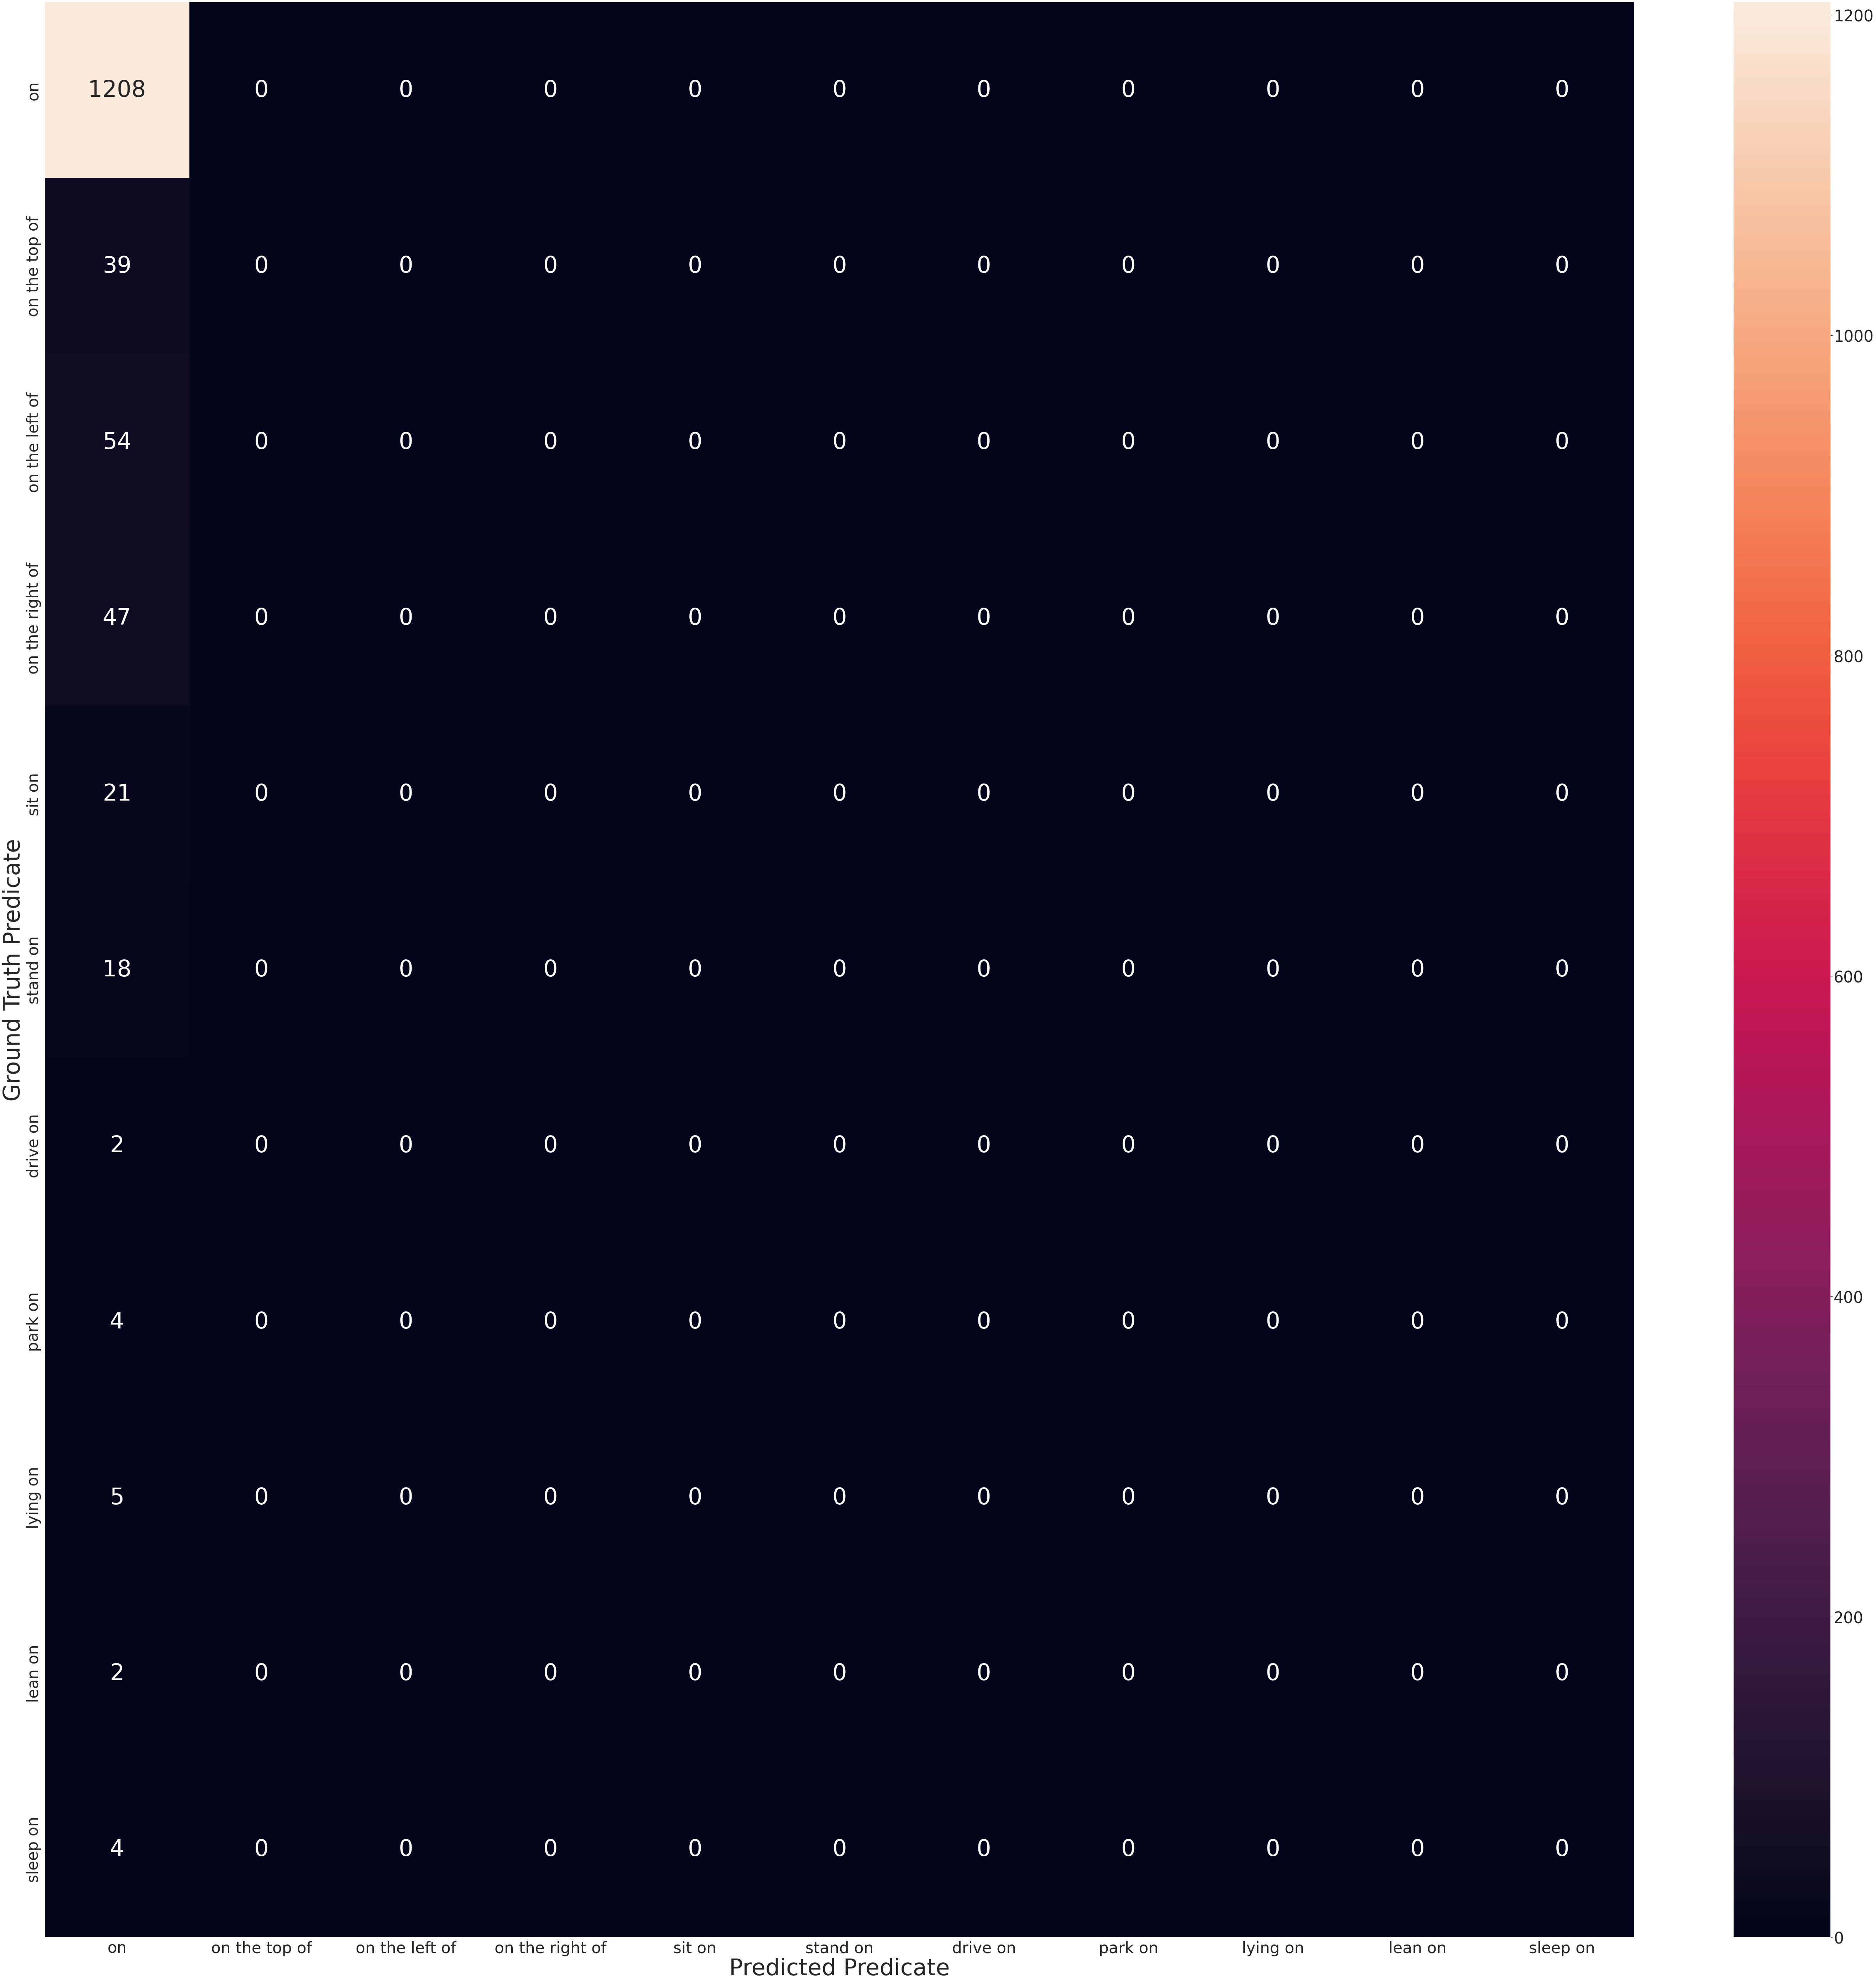

In [62]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = filt_confusion_matrix

df_cm = pd.DataFrame(array, index=filt_classes, columns=filt_classes)
plt.figure(figsize = (100,100))
sn.set(font_scale=4) # for label size
p = sn.heatmap(df_cm, annot=True, annot_kws={"size": 64}, fmt='.4g') # font size
p.set_xlabel("Predicted Predicate", fontsize = 64)
p.set_ylabel("Ground Truth Predicate", fontsize = 64)


In [52]:
cfg = get_vrd_cfg()
test_dataset = DatasetCatalog.get("vrd_val")
test_dataloader = build_detection_test_loader(dataset=test_dataset,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)

data_iter = iter(test_dataloader)
total_relationships = 0
top_rel = [0 for _ in range(70)]
for i in data_iter:
    data = next(data_iter)[0]

    #Evaluate on Ground Truth for now
    if (len(data["relationships"]['subj_bboxes']) == 0):
        #no relationship annotations for the given image
        continue
    for rel in data["relationships"]['pred_classes']:
        top_rel[rel] += 1
    total_relationships +=  len(data['relationships']['pred_classes'])

KeyboardInterrupt: 

In [25]:
total_relationships

3714

# FineTuned

In [ ]:
import torch
import torch.nn as nn
from config import get_vrd_cfg
from detectron2.data import (
    DatasetCatalog, DatasetMapper,
    build_detection_train_loader,
    build_detection_test_loader,
)
import wandb
import time
import torch.optim as optim
import detectron2.data.transforms as T
from torch.optim.lr_scheduler import StepLR

class MLP(nn.Module):
    """
      Multi Layer Perceptron with one hidden layer
    """

    def __init__(self, in_features, out_features=None, hidden_features=None, act_layer=nn.LeakyReLU, drop=0.5):
        super().__init__()

        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        
        return x
        
        
class FinetunedCE(nn.Module):
    """
     Finetuned model for VLTransE. Evaluation on embeddings potential
    """

    def __init__(self, cfg, use_language, vltrans_checkpoint_path=None, in_features=256, out_features=100, hidden_features=256, act_layer=nn.LeakyReLU, drop=0.2):
        """
            Arguments:
                use_language: whether to use langauge features or not
                in_features: what is the output embedding size of VLTransE
                hidden_features: MLP #hidden units
                out_features: MLP #output units
                act_layer: MLP activation function
                drop: MLP dropout rate
        """
        super().__init__()
        
        self.use_language = use_language
        
        in_features = in_features * 3 # 3 visual embeddings by default
        if (use_language):
            in_features += in_features * 2 # two more language embeddings
        self.mlp = MLP(in_features, out_features, hidden_features, act_layer, drop)
        
        
        self.vltranse = VLTransE(cfg)
        if (vltrans_checkpoint_path):
            load_checkpoint(self.vltranse, vltrans_checkpoint_path)

    def forward(self, data):
        """
        Compute the Cross Entropy loss
        
        1/ get visual features
        2/ get language features (except predicate)
        3/ concatenate them
        4/ call mlp
        5/ return logits
        """
        
        fc_features = self.vltranse(data, negative_examples=None, get_fc_features=True)
         
        if (self.use_language):
            x = torch.cat([fc_features['textual']['subj'],
                       fc_features['textual']['obj'],
                       fc_features['visual']['subj'],
                       fc_features['visual']['pred'],
                       fc_features['visual']['obj']], dim=1)
            
        else:
            x = torch.cat([fc_features['visual']['subj'],
                       fc_features['visual']['pred'],
                       fc_features['visual']['obj']], dim=1)
        
        return self.mlp(x)
        

def train_finetuned_ce(model_name="vltranse_finetuned", dataset_name="vrd", chkpoint_path=None, use_language = False, emb_features = 256, vltrans_checkpoint_path='../checkpoint/vrd2_model_transr_23000.pt'):
    """
        Train a finetuned model of the embeddings under supervision.
    """
    cfg = get_vrd_cfg()
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5
    predicates = get_predicate_classes(dataset_name)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FinetunedCE(cfg, use_language=use_language, vltrans_checkpoint_path=None, in_features=emb_features, out_features=len(predicates))
    model.to(device)
    if (chkpoint_path):
        chkpoint = torch.load(chkpoint_path)
        model.load_state_dict(chkpoint)
        
    criterion = nn.CrossEntropyLoss(reduction="mean")
    learning_rate = 0.00001
    momentum = 0.9
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

    # dataset train
    train_dataset = DatasetCatalog.get(f"{dataset_name}_train")
    train_dataloader = build_detection_test_loader(dataset=train_dataset,
        mapper=DatasetMapper(cfg, is_train=True, augmentations=[
            T.Resize((800, 800))
        ])
    )
    data_iter = iter(train_dataloader)

    # dataset test
    test_dataset = DatasetCatalog.get("vrd_val")
    test_dataloader = build_detection_test_loader(dataset=test_dataset,
        mapper=DatasetMapper(cfg, is_train=True, augmentations=[
            T.Resize((800, 800))
        ])
    )
    
    #train params
    n_epochs = 8
    num_ex = len(train_dataset)
    n_iters = num_ex * n_epochs
    log_interval = 20
    
    #wandb for observations
    project_name = '_'.join((model_name, 'lang' if use_language else 'nolang'))
    wandb.init(project=project_name, entity="herobaby71")
    wandb.config = {
        "seed": 0,
        "learning_rate": learning_rate,
        "momentum": 0.9,
        "epochs": n_epochs,
        "n_iters": n_iters,
        "batch_size": 1,
    }
    wandb.watch(model, log="all", log_freq=log_interval)
    
    #train
    running_loss = 0
    it = 0
    
    for i in range(n_iters):
        #get datapoint
        try:
            data = next(data_iter)[0]
        except StopIteration:
            print(
                "iterator has reach its end at iteration {}. Initializing a new iterator.".format(
                    str(i)
                )
            )
            data_iter = iter(train_dataloader)
            data = next(data_iter)[0]
        
        # image has only one relationship, cannot train
        if (len(data["relationships"]["subj_bboxes"]) < 1):
            print("an image has been removed for this batch")
            continue

        # other exclusion due to bad label
        if ("1841.jpg" in data["file_name"]):
            print("this image has bad label and has been removed.")
            continue
            
        #get ground_truth_logit
        gt_logit = torch.tensor(data['relationships']['pred_classes'], dtype=torch.long, device=device)
        pred_cls = model(data)
        
        #loss
        optimizer.zero_grad()
        loss = criterion(pred_cls, gt_logit)
        loss.backward()
        optimizer.step()
        
        #verbose
        running_loss += loss.item()
        if (it % log_interval == log_interval - 1):
            print(f'[{it // num_ex + 1}, {it + 1:5d}] loss: {running_loss / log_interval:.3f}')
            wandb.log(
                {
                    "loss": running_loss / log_interval,
                    "lr": scheduler.get_last_lr()[0]
                },
                step=it,
            )
            running_loss = 0
        
        if (i % 2000 == 1999):
            PATH = '../checkpoint/{}_{}.pth'.format(model_name, i + 1)
            torch.save(model.state_dict(), PATH)
            scheduler.step()
            
            #Set model to evaluation mode
            model.eval()
            
            #Validation loss
            test_data_iter = iter(test_dataloader)
            test_loss = 0
            valid_datapoint = 0
            with torch.no_grad():
                for j in range(len(test_dataset)):
                    data_test = next(test_data_iter)[0]
                    
                    if (len(data_test["relationships"]["subj_bboxes"]) < 1):
                        print("an image has been removed for this batch")
                        continue
                    
                    gt_logit = torch.tensor(data_test['relationships']['pred_classes'], dtype=torch.long, device=device)
                    pred_cls = model(data_test)
                    loss = criterion(pred_cls, gt_logit)
                    test_loss += loss.item()
                    valid_datapoint += 1
            
            wandb.log(
                {
                    "loss_validation": test_loss / valid_datapoint
                },
                step=it,
            )
            
            #Set model to training mode
            model.train()
        it += 1


In [ ]:
finetuned_cd_chkpoint = "../checkpoint/model_finetuned_ce_4000.pth"
train_finetuned_ce(chkpoint_path=finetuned_cd_chkpoint)

## Eval Finetuning

In [ ]:
import collections
import torch
    
def eval_finetuned_ce(dataset_name="vrd", chkpoint_path="../checkpoint/model_finetuned_ce_scheduler_12000.pth", use_language = False, emb_features = 256):
    """
        Evaluate the finetuned model of the embeddings
    """
    cfg = get_vrd_cfg()
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .6
    predicates = get_predicate_classes(dataset_name)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FinetunedCE(cfg, use_language=use_language, vltrans_checkpoint_path=None, in_features=emb_features, out_features=len(predicates))
    model.to(device)
    if (chkpoint_path):
        chkpoint = torch.load(chkpoint_path)
        model.load_state_dict(chkpoint)
    
    # dataset
    cfg.DATASETS.TEST = ("vrd_val", )

    test_dataset = DatasetCatalog.get("vrd_val")
    test_dataloader = build_detection_test_loader(dataset=test_dataset,
        mapper=DatasetMapper(cfg, is_train=True, augmentations=[
            T.Resize((800, 800))
        ])
    )
    
    data_iter = iter(test_dataloader)
    
    confusion_matrix = np.zeros((len(predicates), len(predicates)))
    label_cnt = [0 for _ in range(len(predicates))]
    total_relationships = 0
    correct_predictions = 0
    with torch.no_grad():
        for i in range(len(test_dataset)):
            data = next(data_iter)[0]

            #Evaluate on Ground Truth for now
            if (len(data["relationships"]['subj_bboxes']) == 0):
                #no relationship annotations for the given image
                continue
            
            # Get the Energy of the prediction
            results = model(data)
            _, predictions = torch.max(results, 1)
            ground_truths = data['relationships']['pred_classes']

            for pred, label in zip(predictions, ground_truths):
                label_cnt[label] += 1
                confusion_matrix[label][pred] += 1
                if (pred == label):
                    correct_predictions += 1
                total_relationships += 1
    return confusion_matrix, correct_predictions / total_relationships, label_cnt

In [ ]:
chkpoint_path="../checkpoint/model_finetuned_ce_scheduler2_{}.pth"
confusion_matrices = []

for iteration in range(2000,22000,2000):
    model_chkpoint = chkpoint_path.format(str(iteration))
    print("\nEvaluation for {}".format(model_chkpoint))
    confusion_matrix, recall, label_cnt = eval_finetuned_ce(chkpoint_path=model_chkpoint)
    print(recall)
    confusion_matrices.append(confusion_matrix)

In [ ]:
# 12000 ce_scheduler 0.35899450117831894
# 8000 ce_scheduler 0.3648860958366064
# 4000 ce_scheduler 0.3686829012830584
# 4000 ce 0.35035349567949725
recall

In [ ]:
pred_classes = get_predicate_classes('vrd')
def ravel(confusion_matrix, cls_label="person"):
    ind = pred_classes.index(cls_label)
    tp = confusion_matrix[ind][ind]
    fp = np.sum(confusion_matrix, axis = 0)[ind] - confusion_matrix[ind][ind]
    fn = np.sum(confusion_matrix, axis = 1)[ind] - confusion_matrix[ind][ind]
    return tp, fp, fn

for cls in pred_classes:
    tp, fp, fn = ravel(confusion_matrix, cls)
    print("Recall {}: {}".format(cls, str(tp/(tp+fn))))

In [ ]:
confusion_matrix

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix
df_cm = pd.DataFrame(array, index = pred_classes, columns = pred_classes)
plt.figure(figsize = (100,100))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

### [Optional] Test Instance Detector (Object detector)

In [ ]:
from detectron2.data import (
    DatasetCatalog, DatasetMapper,
    build_detection_train_loader,
    build_detection_test_loader,
)
from config import get_vrd_cfg
import detectron2.data.transforms as T

cfg = get_vrd_cfg()
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .6
cfg.DATASETS.TEST = ("vrd_val", )

#test dataset
test_dataset = DatasetCatalog.get("vrd_val")
test_dataloader = build_detection_test_loader(dataset=test_dataset,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)

#train dataset


In [ ]:
a = copy.deepcopy(object_classes)
a.remove('shirt')

In [ ]:
target = torch.empty(3, dtype=torch.long).random_(5)
relationships = {
    'subj': torch.empty(3, dtype=torch.long).random_(99),
    'obj': torch.empty(3, dtype=torch.long).random_(99),
    'pred': torch.empty(3, dtype=torch.long).random_(99),
}

In [ ]:
list(zip(relationships['subj'], relationships['pred'], relationships['obj']))

In [ ]:
subj_neg = pred_neg = obj_neg = 10

In [ ]:
subj_language_negatives = [[(1, 2, 3), (4, 7, 0), (subj_neg, pred_neg, obj_neg)],
                               [(5, 1, 7), (7, 8, obj_neg), (subj_neg, pred_neg, obj_neg)]]

In [ ]:
for i in range(len(subj_language_negatives[0])):
    neg_example = [item[i] for item in subj_language_negatives]
    print(neg_example)

In [ ]:
subj_negatives = copy.deepcopy(object_classes)
subj_negatives.remove(relationships['subj'])
negative_examples = [[obj, relat] for obj in object_classes]

In [ ]:
model = VLTransE(cfg)
device = torch.device("cuda")
model.to(device)

#Run only once
model.eval()

In [ ]:
chkpoint_path = '../checkpoint/'
model_name = 'vrd2_model_transr_23000.pt'
chkpoint_full_path = os.path.join(chkpoint_path, model_name)
it, start_epoch, losses = load_checkpoint(model, chkpoint_full_path)

In [ ]:
from collections import defaultdict
from detectron2.evaluation import COCOEvaluator, DatasetEvaluator, DatasetEvaluators, inference_on_dataset

object_classes = model.object_classes

class Counter(DatasetEvaluator):
    def reset(self):
        self.count = 0
        self.gt_count = 0
        self.object_areas = defaultdict(list)
        
    def process(self, inputs, outputs):
        for output in outputs:
            self.count += len(output["instances"])
        
        for inp in inputs:
            self.gt_count += len(inp["instances"])

            annotations = inp['instances'].get_fields()    
            for box, cls in zip(annotations['gt_boxes'], annotations['gt_classes']):
                object_width = box[2] - box[0] + 1
                object_height = box[3] - box[1] + 1
                object_area = object_width * object_height
                self.object_areas['area-{}'.format(object_classes[cls])].append(object_area)
                
    def evaluate(self):
        # save self.count somewhere, or print it, or return it.
        resulting_dict = {"count": self.count, "gt_count": self.gt_count, "object_average_area": {}}
        
        for key, areas in self.object_areas.items():
            resulting_dict["object_average_area"][key] = sum(areas) / len(areas)
        
        return resulting_dict
    
def beatify_detectron2_results(eval_results):
    """
        Beautify the results output by detectron2
    """
    object_areas = eval_results['object_average_area']
    object_area_ap = {}
    
    for eval_method, eval_result in eval_results.items():
        if (eval_method == 'count'):
            print("Total Objects Detected:", eval_result)
        elif (eval_method == 'gt_count'):
            print("Total Labeled Objects:", eval_result)
        elif (eval_method == 'object_average_area'):
            continue
        else:
            print("Evaluation results for {}".format(eval_method))

            resulting_string = ""
            for i, (key, res) in enumerate(eval_result.items()):
                resulting_string = "".join((resulting_string, "|   {:>16}\t->\t{:5.2f}".format(key, res)))
                if ((i + 1) <= 6):
                    resulting_string = "".join((resulting_string, "   |"))
                if ((i + 1) == 6):
                    resulting_string = "".join((resulting_string, "\nEvaluation results by object category\n"))
                elif ((i + 1) > 6):
                    object_cls = key.split('-')[1]
                    area_key = 'area-{}'.format(object_cls)
                    object_area = object_areas[area_key]
                    
                    resulting_string = "".join((resulting_string, "( {:5.2f} area )\t|".format(object_area)))
                    object_area_ap[object_cls] = (res, object_area)
                    
                if ((i + 1) % 2 == 0):
                    resulting_string = "".join((resulting_string, "\n"))
            print(resulting_string)
            
    return object_area_ap

##### Object Detector Evaluation for Test Dataset

In [ ]:
eval_results = inference_on_dataset(
    model.detectron,
    test_dataloader,
    DatasetEvaluators([COCOEvaluator('vrd_val', output_dir="../generated/coco_evaluations_val"), Counter()]))


In [ ]:
object_area_ap = beatify_detectron2_results(eval_results)

In [ ]:
import seaborn as sns
import pandas as pd

test_object_data = [ (key, item[0], item[1]) for key, item in object_area_ap.items()]

area_ap_df = pd.DataFrame(pd.DataFrame(list(test_object_data),
               columns =['Object', 'AP', 'Area']))

sns.scatterplot(data=area_ap_df, x="Area", y="AP")


In [ ]:
rank_ap = np.argsort([item[1] for item in test_object_data])
ranked_object = np.array([item[0] for item in test_object_data])[rank_ap]
print("Worst Performing Objects:", ranked_object[:20])

##### Object detector performance for Train Dataset

In [ ]:
eval_results = inference_on_dataset(
    model.detectron,
    train_dataloader,
    DatasetEvaluators([COCOEvaluator('vrd_train', output_dir="../generated/coco_evaluations_train/"), Counter()]))

In [ ]:
object_area_ap = beatify_detectron2_results(eval_results)

In [ ]:
import seaborn as sns
import pandas as pd

train_object_data = [ (key, item[0], item[1]) for key, item in object_area_ap.items()]

area_ap_df = pd.DataFrame(pd.DataFrame(list(train_object_data),
               columns =['Object', 'AP', 'Area']))

sns.scatterplot(data=area_ap_df, x="Area", y="AP")


In [ ]:
rank_ap = np.argsort([item[1] for item in train_object_data])
ranked_object = np.array([item[0] for item in train_object_data])[rank_ap]
print("Worst Performing Objects:", ranked_object[:20])

### [Optional] Test

In [ ]:
from detectron2.data import (
    DatasetCatalog, DatasetMapper,
    build_detection_train_loader,
    build_detection_test_loader,    
)
from config import get_vrd_cfg
import detectron2.data.transforms as T

cfg = get_vrd_cfg()

# DEPRECARTED: Old Dataloader Code
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .6
# cfg.DATASETS.TRAIN = ("vrd_val", )
# test_dataloader = build_detection_train_loader(cfg,
#     mapper=DatasetMapper(cfg, is_train=True, augmentations=[
#         T.Resize((800, 800))
#     ])
# )

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .6

In [ ]:
model = RelTransR(cfg)
device = torch.device("cuda")
model.to(device)

#Run only once
model.eval()

#Load Model
chkpoint_path = '../checkpoint/'
model_name = 'vltranse_max_negative_8000.pt'
chkpoint_full_path = os.path.join(chkpoint_path, model_name)
it, start_epoch, losses = load_checkpoint(model, chkpoint_full_path)

In [ ]:
# Get triples that are in the training set
import os, json

trained_triples_path = '../generated/trained_triples.json'
trained_triples = {}
if (os.path.exists(trained_triples_path)):
    with open(trained_triples_path, 'r') as file:
        trained_triples = json.load(file)
else:
    iter_dataloader = iter(train_dataloader)
    n_iters = len(train_dataloader.dataset.dataset)
    for i in range(n_iters):
        print(i)
        data = next(iter_dataloader)[0]
        relationships = data['relationships']
        for j in range(len(relationships['subj_classes'])):
            subj_cls = model.object_classes[relationships['subj_classes'][j]]
            pred_cls = model.predicate_classes[relationships['pred_classes'][j]]
            obj_cls = model.object_classes[relationships['obj_classes'][j]]
            trained_triples['{}-{}-{}'.format(subj_cls, pred_cls, obj_cls)] = 1



#### EVAL 1/ RELATIONSHIP PREDICTION TASK (NO GROUND TRUTH LABELS)

In [ ]:
import collections
import torch

eval_config = [
    'triple_dist', #multiply subj_dist, pred_dist, obj_dist
    'pred_dist', #only pred_dist
    'pred_subtract_dist', # multiply pred_dist with subtract_dist
    'pred_transe_dist', # multiply pred_dist with transe_dist
    'triple_subtract_dist', #multiply triple_dist with subtract_dist
    'triple_transe_dist', #multiply triple_dist with transe_dist
]

def get_top_nre_relationships(data, nre=50, config='triple_dist'):
    """
        Get the top 50 or 100 relationships for a given input data (image)
        Input:
            data (Dictionary): input dictionary to the model
            nre (Integer): select top n scored relationships
            use_detector_score (Boolean): use the detectron2 detector score
            config (String Selection): see eval_config above
        Return:
            top_n_relationships (Dictionary): top nre relationships based on the `config` scoring metric
    """
    if (config not in eval_config):
        print("Error: ensure that the distance metric is one of the following options: ", eval_config)
    
    relationships = data['relationships']
    predicate_distances, subject_distances, object_distances, predicate_subtract_distances, transe_distances = model.get_predicate_distances(data, is_rel_eval=True)
    all_possible_relationships = collections.defaultdict(list) # {scores: [], subj_classes:[], pred_classes:[], obj_classes:[], subj_bboxes:[], obj_bboxes:[]}
    top_n_relationships = collections.defaultdict(list) # 

    # Iterate through the possible relationships
    for j, (pred_dists, subj_dists, obj_dists) in enumerate(zip(predicate_distances, subject_distances, object_distances)):

        #labels for subject and object
        subj_class = relationships["subj_classes"][j]
        obj_class = relationships["obj_classes"][j]
        subj_bbox = relationships["subj_bboxes"][j]
        obj_bbox = relationships["obj_bboxes"][j]
        subj_detection_score = relationships["subj_scores"][j]
        obj_detection_score = relationships["obj_scores"][j]
        
        #multiply pred, subj, obj
        #Compute scores for the 71 possible predicate and compute the score
        scoring_distances = []
        if (config == 'triple_dist'):
            scoring_distances = [item_pred.cpu()*item_subj.cpu()*item_obj.cpu() for item_pred, item_subj, item_obj in zip(pred_dists, subj_dists, obj_dists)]
        elif (config == 'pred_dist'):
            scoring_distances = [item_pred.cpu() for item_pred in pred_dists]
        elif (config == 'pred_subtract_dist'):
            scoring_distances = [item_pred.cpu()*item_subtract.cpu() for item_pred, item_subtract in zip(pred_dists, predicate_subtract_distances[j])]
        elif (config == 'pred_transe_dist'):
            scoring_distances = [item_pred.cpu()*item_transe.cpu() for item_pred, item_transe in zip(pred_dists, transe_distances[j])]
        elif (config == 'triple_subtract_dist'):
            scoring_distances = [item_pred.cpu()*item_subj.cpu()*item_obj.cpu()*item_subtract.cpu() for item_pred, item_subj, item_obj, item_subtract in zip(pred_dists, subj_dists, obj_dists, predicate_subtract_distances[j])]
        elif (config == 'triple_transe_dist'):
            scoring_distances = [item_pred.cpu()*item_subj.cpu()*item_obj.cpu()*item_transe.cpu() for item_pred, item_subj, item_obj, item_transe in zip(pred_dists, subj_dists, obj_dists, transe_distances[j])]
            
        #Adding to all_possible_relationships to rank
        for ind, distance_score in enumerate(scoring_distances):
            all_possible_relationships["subj_classes"].append(subj_class.cpu())
            all_possible_relationships["pred_classes"].append(ind)
            all_possible_relationships["obj_classes"].append(obj_class.cpu())
            all_possible_relationships["subj_bboxes"].append(subj_bbox)
            all_possible_relationships["obj_bboxes"].append(obj_bbox)
            all_possible_relationships["distance_scores"].append(distance_score)
            all_possible_relationships["subj_detection_scores"].append(subj_detection_score.detach().cpu().numpy())
            all_possible_relationships["obj_detection_scores"].append(obj_detection_score.detach().cpu().numpy())

    #rank to get the top 50, 100 relationships
    sorted_by_distance = np.argsort(all_possible_relationships["distance_scores"])
    
    for key, val in all_possible_relationships.items():
        sorted_val = np.array(val)[sorted_by_distance]
        
        top_n_relationships[key] = sorted_val
        if (nre is not None and len(val) > nre):
            top_n_relationships[key] = sorted_val[:nre]
            
    return top_n_relationships

def eval_per_image(gt_relationships, pred_relationships, gt_thr=0.5, trained_triples=None, model=None):
    """
        Iterate through the ground truth relationship of the image and check
            whether they are in the top 50 or 100, while ensuring that the IoU threshhold is above 50%
            
        Input:
            gt_relationships: ground truth relationships
            pred_relationships: top @n predicted relationships with bounding boxes, etc.
            gr_thr: IoU threshold
            trained_triples: if specified, perform zeroshot evaluation
        Return:
            tp: number of true positives
            n_gt_labels: number of ground truth labels to compute recall
    """
    n_pred_labels = len(pred_relationships["subj_bboxes"])
    n_gt_labels = len(gt_relationships["subj_bboxes"])
    n_zeroshot_gt_labels_set = set() # only used if trained_triples is specified
    visited = set() #track if ground truth has be visited
    
    tp = np.zeros((n_pred_labels,1))
    fp = np.zeros((n_pred_labels,1))
    for j in range(n_pred_labels):
        pred_triple_cls = np.array((pred_relationships["subj_classes"][j], pred_relationships["pred_classes"][j], pred_relationships["obj_classes"][j]))
        obj_bboxes = pred_relationships["obj_bboxes"][j][0]
        subj_bboxes = pred_relationships["subj_bboxes"][j][0]
        
        max_iou = gt_thr #track best overlap
        kmax = -1 #track visited

        for k in range(n_gt_labels):
            gt_triple_cls = np.array((gt_relationships["subj_classes"][k], gt_relationships["pred_classes"][k], gt_relationships["obj_classes"][k]))
            
            if (trained_triples is not None):
                gt_subj_cls = model.object_classes[gt_relationships['subj_classes'][k]]
                gt_pred_cls = model.predicate_classes[gt_relationships['pred_classes'][k]]
                gt_obj_cls = model.object_classes[gt_relationships['obj_classes'][k]]
                gt_triple_cls_label = '-'.join((gt_subj_cls, gt_pred_cls, gt_obj_cls))

                # if the label is in the training dataset, ignore
                if (gt_triple_cls_label in trained_triples):
                    continue
                    
                n_zeroshot_gt_labels_set.add(k)
                
            # Verify prediction labels match ground truth labels
            if (np.linalg.norm(gt_triple_cls - pred_triple_cls) != 0):
                continue
            # Verify that the ground truth labels has not been visited before
            if (k in visited):
                continue
            
            # Check IoU to make sure that the predicted bbox > threshold of 50%
            gt_subj_bboxes = gt_relationships["subj_bboxes"][k][0]
            gt_obj_bboxes = gt_relationships["obj_bboxes"][k][0]
            
            # Intersection between predicted bbox and gt_bbox
            subj_intersection_bbox = np.array([max(subj_bboxes[0],gt_subj_bboxes[0]),
                                                max(subj_bboxes[1],gt_subj_bboxes[1]),
                                                min(subj_bboxes[2],gt_subj_bboxes[2]),
                                                min(subj_bboxes[3],gt_subj_bboxes[3])])
            
            obj_intersection_bbox = np.array([max(obj_bboxes[0],gt_obj_bboxes[0]),
                                                max(obj_bboxes[1],gt_obj_bboxes[1]),
                                                min(obj_bboxes[2],gt_obj_bboxes[2]),
                                                min(obj_bboxes[3],gt_obj_bboxes[3])])
            
            subj_intersection_bbox_width = subj_intersection_bbox[2] - subj_intersection_bbox[0] + 1;
            subj_intersection_bbox_height = subj_intersection_bbox[3] - subj_intersection_bbox[1] + 1;

            obj_intersection_bbox_width = obj_intersection_bbox[2] - obj_intersection_bbox[0] + 1;
            obj_intersection_bbox_height = obj_intersection_bbox[3] - obj_intersection_bbox[1] + 1;
                        
            # Check overlapping
            if (subj_intersection_bbox_width > 0 and subj_intersection_bbox_height > 0 and
                obj_intersection_bbox_width > 0 and obj_intersection_bbox_height > 0):
                
                # [subject] compute overlap as area of intersection / area of union
                subj_intersection_area = subj_intersection_bbox_width * subj_intersection_bbox_height
                subj_union_area = (subj_bboxes[2] - subj_bboxes[0] + 1) * (subj_bboxes[3] - subj_bboxes[1] + 1) + \
                                (gt_subj_bboxes[2] - gt_subj_bboxes[0] + 1) * (gt_subj_bboxes[3] - gt_subj_bboxes[1] + 1) - subj_intersection_area
                subj_iou = subj_intersection_area / subj_union_area

                # [object] compute overlap as area of intersection / area of union
                obj_intersection_area = obj_intersection_bbox_width * obj_intersection_bbox_height
                obj_union_area = (obj_bboxes[2] - obj_bboxes[0] + 1) * (obj_bboxes[3] - obj_bboxes[1] + 1) + \
                                (gt_obj_bboxes[2] - gt_obj_bboxes[0] + 1) * (gt_obj_bboxes[3] - gt_obj_bboxes[1] + 1) - obj_intersection_area
                obj_iou = obj_intersection_area / obj_union_area

                 
                # only need to evaluate the minimum overlap ratio to test against the threshold
                min_iou = min(subj_iou, obj_iou)

                # makes sure that this object is detected according
                # to its individual threshold
                if (min_iou >= max_iou):
                    max_iou = min_iou;
                    kmax = k;
            
        if (kmax > -1):
            visited.add(kmax)
            tp[j] = 1
        else:
            fp[j] = 1;

    if (trained_triples is not None):
        return tp.sum(), len(n_zeroshot_gt_labels_set)
            
    return tp.sum(), n_gt_labels


def eval_dataset(dataloader, model, nre=50, config='triple_dist', trained_triples=None):
    total_true_positive = 0
    total_relationships = 0

    cumulative_recall = []
    recall = 0
    
    n_examples = len(dataloader.dataset)
    test_data_iter = iter(dataloader)
    for i in range(n_examples):
        data = next(test_data_iter)[0]
        gt_relationships = data["relationships"].copy()
        relationships = None
        top_predicted_relationships = {}

        if (len(gt_relationships['subj_bboxes']) == 0):
            #no relationship annotations for the given image
            continue

        with torch.no_grad():
            #get predicted relationships from the object detector
            relationships = model.get_predicted_relationships(data)
            data['relationships'] = relationships

        if (len(relationships['subj_bboxes']) == 0):
            #no relationship annotations for the given image
            continue

        if (i % 20 == 0 and i > 0):
            recall =  total_true_positive / total_relationships * 100
            cumulative_recall.append(recall)
            print("|----------------------Iter {}------------------------|".format(i))
            print("| TOP {} |               Recall {:5.2f}               |".format(nre, recall))

        # Get the top 
        top_predicted_relationships = get_top_nre_relationships(data, nre, config=config)
        image_true_positive, image_relationships = eval_per_image(gt_relationships, top_predicted_relationships, 0.5, trained_triples, model)
        
        total_true_positive += image_true_positive
        total_relationships += image_relationships

    recall =  total_true_positive / total_relationships * 100
    print("|----------------------Iter {}------------------------|".format(i))
    print("| TOP {} |               Recall {:5.2f}               |".format(nre, recall))
    cumulative_recall.append(recall)
    
    return cumulative_recall

##### Test Data Evaluation

In [ ]:
#test dataset
cfg.DATASETS.TEST = ("vrd_val", )

test_dataset = DatasetCatalog.get("vrd_val")
# test_dataloader = build_detection_test_loader(dataset=test_dataset,
#     mapper=DatasetMapper(cfg, is_train=True, augmentations=[
#         T.Resize((800, 800))
#     ])
# )


In [ ]:
recall_results = {}
i = 0
for is_zeroshot in [False, True]:
    for nre in [50, 100]:
        for conf in eval_config:
            if (i == 0):
                i+=1
                continue
            test_dataloader = build_detection_test_loader(dataset=test_dataset,
                mapper=DatasetMapper(cfg, is_train=True, augmentations=[
                    T.Resize((800, 800))
                ])
            )
            with torch.no_grad():
                if (is_zeroshot):
                    print(('is_zeroshot', nre, conf))
                    recall_results[('is_zeroshot', nre, conf)] = eval_dataset(test_dataloader, model, nre=nre, config=conf, trained_triples=trained_triples)
                else:
                    print(('not_zeroshot', nre, conf))
                    recall_results[('not_zeroshot',nre, conf)] = eval_dataset(test_dataloader, model, nre=nre, config=conf, trained_triples=None)

            test_dataloader = None
            del test_dataloader
            

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .6
cfg.DATASETS.TRAIN = ("vrd_val", )
del test_dataloader
del test_data_iter
test_dataloader = build_detection_train_loader(cfg,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)
test_data_iter = iter(test_dataloader)

In [ ]:
recall_results_path = '../generated/results_recall_vrd2_model_transr_23000.json'

with open(recall_results_path, 'w') as file:
    file.write(json.dumps(recall_results))

##### Train Data Evaluation

In [ ]:
#train dataset
cfg.DATASETS.TEST = ("vrd_train", )

train_dataset = DatasetCatalog.get("vrd_train")
train_dataloader = build_detection_test_loader(dataset=train_dataset,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)

In [ ]:
recall_results = {}
for is_zeroshot in [False, True]:
    for nre in [50, 100]:
        for conf in eval_config:
            train_dataloader = build_detection_test_loader(dataset=train_dataset,
                mapper=DatasetMapper(cfg, is_train=True, augmentations=[
                    T.Resize((800, 800))
                ])
            )
            with torch.no_grad():
                if (is_zeroshot):
                    print(('is_zeroshot', nre, conf))
                    recall_results[('is_zeroshot', nre, conf)] = eval_dataset(train_dataloader, model, nre=nre, config=conf, trained_triples=trained_triples)
                else:
                    print(('not_zeroshot', nre, conf))
                    recall_results[('not_zeroshot',nre, conf)] = eval_dataset(train_dataloader, model, nre=nre, config=conf, trained_triples=None)

            train_data_iter = None
            del train_dataloader
            

#### EVAL 2/ PREDICATE PREDICTION TASK (GROUND TRUTH BOUNDING BOXES AND LABELS PROVIDED)

In [ ]:
import numpy as np
#Evalutation of the models performance on detective visual predicate
#default
total_true_positive = 0
total_true_positive_5 = 0
total_relationships = 0

total_true_positive_zeroshot = 0
total_true_positive_5_zeroshot = 0
total_relationships_zeroshot = 0

#sub
total_true_positive_sub = 0
total_true_positive_5_sub = 0

total_true_positive_sub_zeroshot = 0
total_true_positive_5_sub_zeroshot = 0

#mul
total_true_positive_mul = 0
total_true_positive_5_mul = 0

total_true_positive_mul_zeroshot = 0
total_true_positive_5_mul_zeroshot = 0

#transe
total_true_positive_transe = 0
total_true_positive_5_transe = 0

total_true_positive_transe_mul = 0
total_true_positive_5_transe_mul = 0

for i in range(n_examples):
    data = next(test_data_iter)[0]
    relationships = data["relationships"]
    
    if (len(relationships['subj_bboxes']) == 0):
        #no relationship annotations for the given image
        continue
    
    with torch.no_grad():
        predicate_distances, predicate_subtract_distances, transe_distances = model.get_predicate_distances(data)
        
    #Verbose
    if (i % 20 == 0 and i > 0):
        recall_zeroshot_1 = 0
        recall_zeroshot_5 = 0
        if (total_relationships_zeroshot > 0):
            recall_zeroshot_1 = total_true_positive_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_5 = total_true_positive_5_zeroshot / total_relationships_zeroshot * 100

        recall_sub_1 = total_true_positive_sub / total_relationships * 100
        recall_sub_5 = total_true_positive_5_sub / total_relationships * 100
        recall_zeroshot_sub_1 = 0
        recall_zeroshot_sub_5 = 0
        if (total_relationships_zeroshot > 0):
            recall_zeroshot_sub_1 = total_true_positive_sub_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_sub_5 = total_true_positive_5_sub_zeroshot / total_relationships_zeroshot * 100        
        
        recall_mul_1 = total_true_positive_mul / total_relationships * 100
        recall_mul_5 = total_true_positive_5_mul / total_relationships * 100
        recall_zeroshot_mul_1 = 0
        recall_zeroshot_mul_5 = 0
        if (total_relationships_zeroshot > 0):
            recall_zeroshot_mul_1 = total_true_positive_mul_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_mul_5 = total_true_positive_5_mul_zeroshot / total_relationships_zeroshot * 100        
        
        recall_transe_1 = total_true_positive_transe / total_relationships * 100
        recall_transe_5 = total_true_positive_5_transe / total_relationships * 100
        
        recall_transe_mul_1 = total_true_positive_transe_mul / total_relationships * 100
        recall_transe_mul_5 = total_true_positive_5_transe_mul / total_relationships * 100
        
        recall_1 =  total_true_positive / total_relationships * 100
        recall_5 = total_true_positive_5 / total_relationships * 100
        print("|----------------------Iter {}------------------------|".format(i))
        print("| Recall top 1 {:5.2f} | Recall zeroshot top 1 {:5.2f} |".format(recall_1, recall_zeroshot_1))
        print("| Recall top 5 {:5.2f} | Recall zeroshot top 5 {:5.2f} |".format(recall_5, recall_zeroshot_5))
        print("| Recall sub top 1 {:5.2f} | Recall zeroshot sub top 1 {:5.2f} |".format(recall_sub_1, recall_zeroshot_sub_1))
        print("| Recall sub top 5 {:5.2f} | Recall zeroshot sub top 5 {:5.2f} |".format(recall_sub_5, recall_zeroshot_sub_5))
        print("| Recall mul top 1 {:5.2f} | Recall zeroshot mul top 1 {:5.2f} |".format(recall_mul_1, recall_zeroshot_mul_1))
        print("| Recall mul top 5 {:5.2f} | Recall zeroshot mul top 5 {:5.2f} |".format(recall_mul_5, recall_zeroshot_mul_5))        
        print("| Recall transe 1 {:5.2f} | Recall transe mul 1 {:5.2f} |".format(recall_transe_1, recall_transe_mul_1))
        print("| Recall transe 5 {:5.2f} | Recall transe mul 5 {:5.2f} |".format(recall_transe_5, recall_transe_mul_5))

    #select top 5 to calculate recall
    
    for j, pred_distance in enumerate(predicate_distances):
        sorted_pred_distance = np.argsort([item.cpu() for item in pred_distance])
        
        top_5_pred = sorted_pred_distance[:5]
        top_1_pred = sorted_pred_distance[0]
        
        #subtract
        sorted_pred_subtract_distance = np.argsort([item.cpu() for item in predicate_subtract_distances[j]])
        top_5_pred_sub = sorted_pred_subtract_distance[:5]
        top_1_pred_sub = sorted_pred_subtract_distance[0]
        
        #transe
        sorted_transe_distances = np.argsort([item.cpu() for item in transe_distances[j]])
        top_5_vtranse = sorted_transe_distances[:5]
        top_1_vtranse = sorted_transe_distances[0]

        #pred * transe
        pred_transe_multiply_distances = [ item1.cpu() * item2.cpu() for item1,item2 in zip(pred_distance, transe_distances[j])]
        top_5_pred_transe = np.argsort(pred_transe_multiply_distances[j].cpu())[:5]
        top_1_pred_transe = np.argsort(pred_transe_multiply_distances[j].cpu())[0]
        
        #pred * sub
        pred_multiply_distances = [ item1.cpu() * item2.cpu() for item1,item2 in zip(pred_distance, predicate_subtract_distances[j])]
        top_5_pred_mul = np.argsort(pred_multiply_distances)[:5]
        top_1_pred_mul = np.argsort(pred_multiply_distances)[0]

        gt_subj = model.object_classes[relationships['subj_classes'][j]]
        gt_pred = model.predicate_classes[relationships['pred_classes'][j]]
        gt_obj = model.object_classes[relationships['obj_classes'][j]]
            
        #compute true positive
        if (top_1_pred == relationships['pred_classes'][j]):
            total_true_positive += 1
        if (relationships['pred_classes'][j] in top_5_pred):
            total_true_positive_5 += 1
        
        if ('{}-{}-{}'.format(gt_subj, gt_pred, gt_obj) not in trained_triples):
            
            #default pred
            if (top_1_pred == relationships['pred_classes'][j]):
                total_true_positive_zeroshot += 1
            if (relationships['pred_classes'][j] in top_5_pred):
                total_true_positive_5_zeroshot += 1
                
            #sub
            if (top_1_pred_sub == relationships['pred_classes'][j]):
                total_true_positive_sub_zeroshot += 1
            if (relationships['pred_classes'][j] in top_5_pred_sub):
                total_true_positive_5_sub_zeroshot += 1
                
            #mul (pred*sub)
            if (top_1_pred_mul == relationships['pred_classes'][j]):
                total_true_positive_mul_zeroshot += 1
            if (relationships['pred_classes'][j] in top_5_pred_mul):
                total_true_positive_5_mul_zeroshot += 1
                
            total_relationships_zeroshot += 1
        
        #sub
        if (top_1_pred_sub == relationships['pred_classes'][j]):
            total_true_positive_sub += 1
        if (relationships['pred_classes'][j] in top_5_pred_sub):
            total_true_positive_5_sub += 1
        
        #pred * sub
        if (top_1_pred_mul == relationships['pred_classes'][j]):
            total_true_positive_mul += 1
        if (relationships['pred_classes'][j] in top_5_pred_mul):
            total_true_positive_5_mul += 1

        #transe
        if (top_1_vtranse == relationships['pred_classes'][j]):
            total_true_positive_transe += 1
        if (relationships['pred_classes'][j] in top_5_vtranse):
            total_true_positive_5_transe += 1
        
        #pred * sub
        if (top_1_pred_transe == relationships['pred_classes'][j]):
            total_true_positive_transe_mul += 1
        if (relationships['pred_classes'][j] in top_5_pred_transe):
            total_true_positive_5_transe_mul += 1
            
    total_relationships += len(predicate_distances)

print("Final recall top 1: ", total_true_positive / total_relationships * 100)
print("Final recall top 5: ", total_true_positive_5 / total_relationships * 100)


In [ ]:
recall_zeroshot_1 = 0
recall_zeroshot_5 = 0
if (total_relationships_zeroshot > 0):
    recall_zeroshot_1 = total_true_positive_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_5 = total_true_positive_5_zeroshot / total_relationships_zeroshot * 100

recall_sub_1 = total_true_positive_sub / total_relationships * 100
recall_sub_5 = total_true_positive_5_sub / total_relationships * 100
recall_zeroshot_sub_1 = 0
recall_zeroshot_sub_5 = 0
if (total_relationships_zeroshot > 0):
    recall_zeroshot_sub_1 = total_true_positive_sub_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_sub_5 = total_true_positive_5_sub_zeroshot / total_relationships_zeroshot * 100        

recall_mul_1 = total_true_positive_mul / total_relationships * 100
recall_mul_5 = total_true_positive_5_mul / total_relationships * 100
recall_zeroshot_mul_1 = 0
recall_zeroshot_mul_5 = 0
if (total_relationships_zeroshot > 0):
    recall_transe_mul_1 = total_true_positive_transe_mul / total_relationships * 100
    recall_transe_mul_5 = total_true_positive_5_transe_mul / total_relationships * 100

recall_1 =  total_true_positive / total_relationships * 100
recall_5 = total_true_positive_5 / total_relationships * 100
print("|----------------------Iter {}------------------------|".format(i))
print("| Recall top 1 {:5.2f} | Recall zeroshot top 1 {:5.2f} |".format(recall_1, recall_zeroshot_1))
print("| Recall top 5 {:5.2f} | Recall zeroshot top 5 {:5.2f} |".format(recall_5, recall_zeroshot_5))
print("| Recall sub top 1 {:5.2f} | Recall zeroshot sub top 1 {:5.2f} |".format(recall_sub_1, recall_zeroshot_sub_1))
print("| Recall sub top 5 {:5.2f} | Recall zeroshot sub top 5 {:5.2f} |".format(recall_sub_5, recall_zeroshot_sub_5))
print("| Recall mul top 1 {:5.2f} | Recall zeroshot mul top 1 {:5.2f} |".format(recall_mul_1, recall_zeroshot_mul_1))
print("| Recall mul top 5 {:5.2f} | Recall zeroshot mul top 5 {:5.2f} |".format(recall_mul_5, recall_zeroshot_mul_5))        
print("| Recall transe 1 {:5.2f} | Recall transe mul 1 {:5.2f} |".format(recall_transe_1, recall_transe_mul_1))
print("| Recall transe 5 {:5.2f} | Recall transe mul 5 {:5.2f} |".format(recall_transe_5, recall_transe_mul_5))
recall_zeroshot_mul_1 = total_true_positive_mul_zeroshot / total_relationships_zeroshot * 100
recall_zeroshot_mul_5 = total_true_positive_5_mul_zeroshot / total_relationships_zeroshot * 100        

recall_transe_1 = total_true_positive_transe / total_relationships * 100
recall_transe_5 = total_true_positive_5_transe / total_relationships * 100

recall_transe_mul_1 = total_true_positive_transe_mul / total_relationships * 100
recall_transe_mul_5 = total_true_positive_5_transe_mul / total_relationships * 100

recall_1 =  total_true_positive / total_relationships * 100
recall_5 = total_true_positive_5 / total_relationships * 100
print("|----------------------Iter {}------------------------|".format(i))
print("| Recall top 1 {:5.2f} | Recall zeroshot top 1 {:5.2f} |".format(recall_1, recall_zeroshot_1))
print("| Recall top 5 {:5.2f} | Recall zeroshot top 5 {:5.2f} |".format(recall_5, recall_zeroshot_5))
print("| Recall sub top 1 {:5.2f} | Recall zeroshot sub top 1 {:5.2f} |".format(recall_sub_1, recall_zeroshot_sub_1))
print("| Recall sub top 5 {:5.2f} | Recall zeroshot sub top 5 {:5.2f} |".format(recall_sub_5, recall_zeroshot_sub_5))
print("| Recall mul top 1 {:5.2f} | Recall zeroshot mul top 1 {:5.2f} |".format(recall_mul_1, recall_zeroshot_mul_1))
print("| Recall mul top 5 {:5.2f} | Recall zeroshot mul top 5 {:5.2f} |".format(recall_mul_5, recall_zeroshot_mul_5))        
print("| Recall transe 1 {:5.2f} | Recall transe mul 1 {:5.2f} |".format(recall_transe_1, recall_transe_mul_1))
print("| Recall transe 5 {:5.2f} | Recall transe mul 5 {:5.2f} |".format(recall_transe_5, recall_transe_mul_5))

In [ ]:
#Evalutation of the models performance on detective visual object (no TransE)
import numpy as np
#total
total_relationships = 0
total_relationships_zeroshot = 0

#default
total_true_positive = 0
total_true_positive_5 = 0
total_true_positive_10 = 0

total_true_positive_zeroshot = 0
total_true_positive_5_zeroshot = 0
total_true_positive_10_zeroshot = 0

#add
total_true_positive_add = 0
total_true_positive_5_add = 0
total_true_positive_10_add = 0

total_true_positive_add_zeroshot = 0
total_true_positive_5_add_zeroshot = 0
total_true_positive_10_add_zeroshot = 0

#mul
total_true_positive_mul = 0
total_true_positive_5_mul = 0
total_true_positive_10_mul = 0

total_true_positive_mul_zeroshot = 0
total_true_positive_5_mul_zeroshot = 0
total_true_positive_10_mul_zeroshot = 0

for i in range(n_examples):
    data = next(test_data_iter)[0]
    relationships = data["relationships"]
    with torch.no_grad():
        object_distances, object_add_distances = model.get_object_distances(data)
        
    #Verbose
    if (i % 20 == 0 and i > 0):
        recall_1 =  total_true_positive / total_relationships * 100
        recall_5 = total_true_positive_5 / total_relationships * 100
        recall_10 = total_true_positive_10 / total_relationships * 100
        recall_zeroshot_1 = 0
        recall_zeroshot_5 = 0
        recall_zeroshot_10 = 0
        if (total_relationships_zeroshot > 0):
            recall_zeroshot_1 = total_true_positive_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_5 = total_true_positive_5_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_10 = total_true_positive_10_zeroshot / total_relationships_zeroshot * 100

        recall_add_1 = total_true_positive_add / total_relationships * 100
        recall_add_5 = total_true_positive_5_add / total_relationships * 100
        recall_add_10 = total_true_positive_10_add / total_relationships * 100
        recall_zeroshot_add_1 = 0
        recall_zeroshot_add_5 = 0
        recall_zeroshot_add_10 = 0        
        if (total_relationships_zeroshot > 0):
            recall_zeroshot_add_1 = total_true_positive_add_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_add_5 = total_true_positive_5_add_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_add_10 = total_true_positive_10_add_zeroshot / total_relationships_zeroshot * 100
        
        recall_mul_1 = total_true_positive_mul / total_relationships * 100
        recall_mul_5 = total_true_positive_5_mul / total_relationships * 100
        recall_mul_10 = total_true_positive_10_mul / total_relationships * 100
        recall_zeroshot_mul_1 = 0
        recall_zeroshot_mul_5 = 0
        recall_zeroshot_mul_10 = 0
        if (total_relationships_zeroshot > 0):
            recall_zeroshot_mul_1 = total_true_positive_mul_zeroshot / total_relationships_zeroshot * 100
            recall_zeroshot_mul_5 = total_true_positive_5_mul_zeroshot / total_relationships_zeroshot * 100        
            recall_zeroshot_mul_10 = total_true_positive_10_mul_zeroshot / total_relationships_zeroshot * 100        
        
        print("|----------------------Iter {}------------------------|".format(i))
        print("| Recall top 1 {:5.2f} | Recall zeroshot top 1 {:5.2f} |".format(recall_1, recall_zeroshot_1))
        print("| Recall top 5 {:5.2f} | Recall zeroshot top 5 {:5.2f} |".format(recall_5, recall_zeroshot_5))
        print("| Recall top 10 {:5.2f} | Recall zeroshot top 10 {:5.2f} |".format(recall_10, recall_zeroshot_10))
        print("| Recall add top 1 {:5.2f} | Recall zeroshot sub top 1 {:5.2f} |".format(recall_add_1, recall_zeroshot_add_1))
        print("| Recall add top 5 {:5.2f} | Recall zeroshot sub top 5 {:5.2f} |".format(recall_add_5, recall_zeroshot_add_5))
        print("| Recall add top 10 {:5.2f} | Recall zeroshot sub top 10 {:5.2f} |".format(recall_add_10, recall_zeroshot_add_10))
        print("| Recall mul top 1 {:5.2f} | Recall zeroshot mul top 1 {:5.2f} |".format(recall_mul_1, recall_zeroshot_mul_1))
        print("| Recall mul top 5 {:5.2f} | Recall zeroshot mul top 5 {:5.2f} |".format(recall_mul_5, recall_zeroshot_mul_5))        
        print("| Recall mul top 10 {:5.2f} | Recall zeroshot mul top 10 {:5.2f} |".format(recall_mul_10, recall_zeroshot_mul_10))        

    #select top 5 to calculate recall
    for j, obj_distance in enumerate(object_distances):
        top_1_obj = np.argsort(obj_distance)[0]
        top_5_obj = np.argsort(obj_distance)[:5]
        top_10_obj = np.argsort(obj_distance)[:10]
        
        #add
        top_1_obj_add = np.argsort(object_add_distances[j])[0]
        top_5_obj_add = np.argsort(object_add_distances[j])[:5]
        top_10_obj_add = np.argsort(object_add_distances[j])[:10]
        
        #pred * add
        obj_multiply_distances = [ item1 * item2 for item1,item2 in zip(obj_distance, object_add_distances[j])]
        top_1_obj_mul = np.argsort(obj_multiply_distances)[0]
        top_5_obj_mul = np.argsort(obj_multiply_distances)[:5]
        top_10_obj_mul = np.argsort(obj_multiply_distances)[:10]

        gt_subj = model.object_classes[relationships['subj_classes'][j]]
        gt_pred = model.predicate_classes[relationships['pred_classes'][j]]
        gt_obj = model.object_classes[relationships['obj_classes'][j]]
            
        #compute true positive        
        if ('{}-{}-{}'.format(gt_subj, gt_pred, gt_obj) not in trained_triples):
            
            #default pred
            if (top_1_obj == relationships['obj_classes'][j]):
                total_true_positive_zeroshot += 1
            if (relationships['obj_classes'][j] in top_5_obj):
                total_true_positive_5_zeroshot += 1
            if (relationships['obj_classes'][j] in top_10_obj):
                total_true_positive_10_zeroshot += 1

            #sub
            if (top_1_obj_add == relationships['obj_classes'][j]):
                total_true_positive_add_zeroshot += 1
            if (relationships['obj_classes'][j] in top_5_obj_add):
                total_true_positive_5_add_zeroshot += 1
            if (relationships['obj_classes'][j] in top_10_obj_add):
                total_true_positive_10_add_zeroshot += 1
                
            #mul (pred*sub)
            if (top_1_obj_mul == relationships['obj_classes'][j]):
                total_true_positive_mul_zeroshot += 1
            if (relationships['obj_classes'][j] in top_5_obj_mul):
                total_true_positive_5_mul_zeroshot += 1
            if (relationships['obj_classes'][j] in top_10_obj_mul):
                total_true_positive_10_mul_zeroshot += 1
                
            total_relationships_zeroshot += 1
        
        #normal
        if (top_1_obj == relationships['obj_classes'][j]):
            total_true_positive += 1
        if (relationships['obj_classes'][j] in top_5_obj):
            total_true_positive_5 += 1
        if (relationships['obj_classes'][j] in top_10_obj):
            total_true_positive_10 += 1
            
        #add
        if (top_1_obj_add == relationships['obj_classes'][j]):
            total_true_positive_add += 1
        if (relationships['obj_classes'][j] in top_5_obj_add):
            total_true_positive_5_add += 1
        if (relationships['obj_classes'][j] in top_10_obj_add):
            total_true_positive_10_add += 1
        
        #pred * add
        if (top_1_obj_mul == relationships['obj_classes'][j]):
            total_true_positive_mul += 1
        if (relationships['obj_classes'][j] in top_5_obj_mul):
            total_true_positive_5_mul += 1
        if (relationships['obj_classes'][j] in top_10_obj_mul):
            total_true_positive_10_mul += 1
    total_relationships += len(object_distances)

print("Final recall top 1: ", total_true_positive / total_relationships * 100)
print("Final recall top 5: ", total_true_positive_5 / total_relationships * 100)

In [ ]:
recall_1 =  total_true_positive / total_relationships * 100
recall_5 = total_true_positive_5 / total_relationships * 100
recall_10 = total_true_positive_10 / total_relationships * 100
recall_zeroshot_1 = 0
recall_zeroshot_5 = 0
recall_zeroshot_10 = 0
if (total_relationships_zeroshot > 0):
    recall_zeroshot_1 = total_true_positive_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_5 = total_true_positive_5_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_10 = total_true_positive_10_zeroshot / total_relationships_zeroshot * 100

recall_add_1 = total_true_positive_add / total_relationships * 100
recall_add_5 = total_true_positive_5_add / total_relationships * 100
recall_add_10 = total_true_positive_10_add / total_relationships * 100
recall_zeroshot_add_1 = 0
recall_zeroshot_add_5 = 0
recall_zeroshot_add_10 = 0        
if (total_relationships_zeroshot > 0):
    recall_zeroshot_add_1 = total_true_positive_add_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_add_5 = total_true_positive_5_add_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_add_10 = total_true_positive_10_add_zeroshot / total_relationships_zeroshot * 100

recall_mul_1 = total_true_positive_mul / total_relationships * 100
recall_mul_5 = total_true_positive_5_mul / total_relationships * 100
recall_mul_10 = total_true_positive_10_mul / total_relationships * 100
recall_zeroshot_mul_1 = 0
recall_zeroshot_mul_5 = 0
recall_zeroshot_mul_10 = 0
if (total_relationships_zeroshot > 0):
    recall_zeroshot_mul_1 = total_true_positive_mul_zeroshot / total_relationships_zeroshot * 100
    recall_zeroshot_mul_5 = total_true_positive_5_mul_zeroshot / total_relationships_zeroshot * 100        
    recall_zeroshot_mul_10 = total_true_positive_10_mul_zeroshot / total_relationships_zeroshot * 100        

print("|----------------------Iter {}------------------------|".format(i))
print("| Recall top 1 {:5.2f} | Recall zeroshot top 1 {:5.2f} |".format(recall_1, recall_zeroshot_1))
print("| Recall top 5 {:5.2f} | Recall zeroshot top 5 {:5.2f} |".format(recall_5, recall_zeroshot_5))
print("| Recall top 10 {:5.2f} | Recall zeroshot top 10 {:5.2f} |".format(recall_10, recall_zeroshot_10))
print("| Recall add top 1 {:5.2f} | Recall zeroshot sub top 1 {:5.2f} |".format(recall_add_1, recall_zeroshot_add_1))
print("| Recall add top 5 {:5.2f} | Recall zeroshot sub top 5 {:5.2f} |".format(recall_add_5, recall_zeroshot_add_5))
print("| Recall add top 10 {:5.2f} | Recall zeroshot sub top 10 {:5.2f} |".format(recall_add_10, recall_zeroshot_add_10))
print("| Recall mul top 1 {:5.2f} | Recall zeroshot mul top 1 {:5.2f} |".format(recall_mul_1, recall_zeroshot_mul_1))
print("| Recall mul top 5 {:5.2f} | Recall zeroshot mul top 5 {:5.2f} |".format(recall_mul_5, recall_zeroshot_mul_5))        
print("| Recall mul top 10 {:5.2f} | Recall zeroshot mul top 10 {:5.2f} |".format(recall_mul_10, recall_zeroshot_mul_10))        


In [ ]:
data_iter = iter(train_dataloader)
data = next(data_iter)[0]
# model = RelTransR(cfg)
# negative_examples = model.generate_negative_examples(data)
# results = model(data,negative_examples)

# Training Scripts

In [19]:
from detectron2.data import (
    DatasetCatalog, DatasetMapper,
    build_detection_train_loader
)
from config import get_vrd_cfg
import detectron2.data.transforms as T

cfg = get_vrd_cfg()
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .6
batch_size = 1

# Dataloaders
if ('test_dataloader' in vars()):
    del test_dataloader

# train_dataloader = build_detection_train_loader(cfg,
#     mapper=DatasetMapper(cfg, is_train=True, augmentations=[
#         T.Resize((800, 800))
#     ])
# )


#### Creating a train_dataloader

In [20]:
#train dataset
cfg.DATASETS.TEST = ("vrd_train", )

train_dataset = DatasetCatalog.get("vrd_train")
train_dataloader = build_detection_train_loader(cfg, dataset=train_dataset,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)

#### Training Parameters

In [21]:
import torch
import wandb
from torch.optim.lr_scheduler import StepLR
torch.manual_seed(0)

#params
n_datapoints = len(train_dataset)
n_iters = cfg.SOLVER.MAX_ITER
num_epochs = int(n_iters / n_datapoints)

#model
model = VLTransE(cfg)
device = torch.device("cuda")
model.to(device)

#scheduler
learning_rate = 0.001
gamma = cfg.SOLVER.GAMMA
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

AttributeError: 'VLTransE' object has no attribute '_load_words_chkpoints'

#### WanDB

In [ ]:
#wandb
log_interval = 20
project_name = "vltranse-maxneg-project"
wandb.init(project=project_name, entity="herobaby71")
wandb.config = {
    "seed": 0,
    "learning_rate": learning_rate,
    "gamma": 0.1,
    "momentum": 0.9,
    "epochs": num_epochs,
    "n_iters": n_iters,
    "batch_size": 1
}
wandb.watch(model, log="all", log_freq=20)

In [ ]:
def train_log(loss, lr, it, epoch, loss_subj, loss_pred, loss_obj, loss_transr):
    # Where the magic happens
    wandb.log({"lr":lr, "epoch": epoch, "loss": loss, "loss_subj": loss_subj, "loss_pred": loss_pred, "loss_obj": loss_obj, "loss_transr":loss_transr}, step=it)

#### Load Checkpoint

In [ ]:
import time
import os

#checkpoint every 2000 steps
chkpoint_it = n_datapoints #create a checkpoint every epoch

it = 0
initial_it = 0 # checkpoint intial iteration to resume training
start_time = time.time()
losses = []

#load checkpoint
load_chkpoint = False
chkpoint_path = '../checkpoint/'
if (load_chkpoint):
    model_name = '' #no checkpoint currently
    chkpoint_full_path = os.path.join(chkpoint_path, model_name)
    it, start_epoch, losses = load_checkpoint(model, chkpoint_full_path, optimizer=optimizer)
    initial_it = it

In [ ]:
# Get triples that are in the training set
import os, json

trained_triples_path = '../generated/trained_triples.json'
trained_triples = {}
if (os.path.exists(trained_triples_path)):
    with open(trained_triples_path, 'r') as file:
        trained_triples = json.load(file)
else:
    iter_dataloader = iter(train_dataloader)
    n_iters = len(train_dataloader.dataset.dataset)
    for i in range(n_iters):
        print(i)
        data = next(iter_dataloader)[0]
        relationships = data['relationships']
        for j in range(len(relationships['subj_classes'])):
            subj_cls = model.object_classes[relationships['subj_classes'][j]]
            pred_cls = model.predicate_classes[relationships['pred_classes'][j]]
            obj_cls = model.object_classes[relationships['obj_classes'][j]]
            trained_triples['{}-{}-{}'.format(subj_cls, pred_cls, obj_cls)] = 1

    with open(trained_triples_path, 'w') as file:
        file.write(json.dumps(trained_triples))

In [ ]:
from collections import defaultdict

def train(model, train_dataloader, n_iters, initial_it=0, n_negatives_per_image=100, model_name="vrd2_model_transr"):
    iter_dataloader = iter(train_dataloader)
    interval_cnt = 0
    
    #Usuable Images (Number of useful images)
    n_useful_images = 0
    
    #Losses
    total_loss = 0
    subj_loss = 0
    obj_loss = 0
    pred_loss = 0
    transr_loss = 0
    
    #start_it
    it = 0
    start_time = time.time()

    for i in range(n_iters):
        #iterator
        try:
            data = next(iter_dataloader)[0]
        except StopIteration:
            print("iterator has reach its end at iteration {}. Initializing a new iterator.".format(str(it)))
            iter_dataloader = iter(train_dataloader)
            data = next(iter_dataloader)[0]

        #continue training from the previous checkpoint
        if (i < initial_it % n_datapoints):
            continue

        if (len(data['relationships']['subj_bboxes']) <= 1):
            #image has only one relationship, cannot train
            print("an image has been removed for this batch")
            continue

        #other exclusion due to bad label
        if ('1841.jpg' in data["file_name"]):
            print("this image has bad label and has been removed.")
            continue
        
        if (i < n_iters):
            # Keep track of the number of useful images
            n_useful_images += 1

        optimizer.zero_grad()

        #forward passes
        negative_examples = {}
        negative_examples = model.generate_negative_examples(data, K=100)
        print(len(data['']))
        print("==================================")
        print(negative_examples)
        return negative_examples
    
        triplet_losses = model(data, negative_examples)

        #compute gradient backward
        final_loss = triplet_losses['obj'] + triplet_losses['pred'] + triplet_losses['subj'] + triplet_losses['transr']
        final_loss.backward()
        optimizer.step()

        #total loss
        total_loss += final_loss.item()
        subj_loss += triplet_losses['subj'].item()
        pred_loss += triplet_losses['pred'].item()
        obj_loss += triplet_losses['obj'].item()
        transr_loss += triplet_losses['transr'].item()

        interval_cnt += 1
        if (it > initial_it and it % log_interval == 0 and it > 0):
            current_loss = total_loss / interval_cnt
            losses.append(current_loss)
            elapsed = time.time() - start_time
            epoch = it / n_datapoints
            print('| it {} | epoch {} | lr {} | ms/batch {:5.2f} | loss {:5.2f}'.format(
                it, int(epoch), scheduler.get_last_lr()[0], elapsed * 1000 / log_interval, current_loss))
            train_log(current_loss, scheduler.get_last_lr()[0], it, int(epoch),
                      loss_subj=subj_loss/interval_cnt, loss_pred=pred_loss/interval_cnt,
                      loss_obj=obj_loss/interval_cnt, loss_transr=transr_loss/interval_cnt)
            total_loss = 0
            subj_loss = 0
            pred_loss = 0
            obj_loss = 0
            transr_loss = 0
            interval_cnt = 0
            start_time = time.time()

        if (it > initial_it and it % chkpoint_it == 0 and it > 0):
            chkpnt = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "it": it,
                "losses": losses
            }
            torch.save(chkpnt, os.path.join(chkpoint_path, f'{model_name}_{str(it)}.pt'))

        #increment total count
        it = it + 1
    return n_useful_images

In [ ]:
n_useful_images = train(model, train_dataloader, n_iters, initial_it=0, n_negatives_per_image=100, model_name="vltranse_max_negative")

In [ ]:
a = """defaultdict(<class 'list'>, {'subj_bboxes': Boxes(tensor([[226., 350., 269., 380.],
        [479., 409., 572., 469.],
        [479., 409., 572., 469.]], device='cuda:0')), 'subj_classes': [73, 26, 26], 'obj_bboxes': Boxes(tensor([[479., 409., 572., 469.],
        [479., 409., 572., 469.],
        [479., 409., 572., 469.]], device='cuda:0')), 'obj_classes': [26, 26, 26], 'union_bboxes': Boxes(tensor([[226., 350., 572., 469.],
        [479., 409., 572., 469.],
        [479., 409., 572., 469.]], device='cuda:0')), 'pred_classes': [70, 70, 70]}), defaultdict(<class 'list'>, {'subj_bboxes': Boxes(tensor([[266., 325., 313., 381.],
        [266., 325., 313., 381.],
        [ 15.,  39., 637., 798.]], device='cuda:0')), 'subj_classes': [55, 55, 75], 'obj_bboxes': Boxes(tensor([[226., 350., 269., 380.],
        [226., 350., 269., 380.],
        [226., 350., 269., 380.]], device='cuda:0')), 'obj_classes': [73, 73, 73], 'union_bboxes': Boxes(tensor([[226., 325., 313., 381.],
        [226., 325., 313., 381.],
        [ 15.,  39., 637., 798.]], device='cuda:0')), 'pred_classes': [70, 70, 46]})]"""

In [ ]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

### [Optional] Test Eval Model Performance

In [ ]:
from detectron2.data import (
    DatasetCatalog, DatasetMapper,
    build_detection_train_loader
)

cfg = get_vrd_cfg()

#model
# model = RelTransR(cfg)
# device = torch.device("cuda")
# model.to(device)

#test dataloader
cfg.DATASETS.TRAIN = ("vrd_val", )
test_dataloader = build_detection_train_loader(cfg,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
        T.Resize((800, 800))
    ])
)

In [ ]:
global_loss = 0
avg_loss = 0
cnt = 0

total_loss = 0
pred_loss = 0
interval_cnt = 0

model.eval()
test_data_iter = iter(test_dataloader)
broken_image = []

with torch.no_grad():
    for i in range(2000):
        data = next(test_data_iter)[0]

        #If there is only one relationship (not suitable to be evaluate with the given loss)
        if (len(data['relationships']['subj_bboxes']) == 1):
            #image has only one relationship, cannot train
            print("an image has been removed for this batch")
            broken_image.append(data)
            continue

        # get negative examples and compute losses
        negative_examples = model.generate_negative_examples(data)
        triplet_losses = model(data, negative_examples)
        final_loss = triplet_losses['obj'] + triplet_losses['subj'] + triplet_losses['pred']

        #output interval loss
        total_loss += final_loss.item()
        pred_loss += triplet_losses['subj'].item()
        interval_cnt += 1
        if (i > 0 and i % 20 == 0):
            current_loss = total_loss / interval_cnt
            pred_current_loss = pred_loss / interval_cnt
            print('| iter: {} | loss {:5.2f} | pred_loss {:5.2f}'.format(i, current_loss, pred_current_loss))
            total_loss = 0
            pred_loss = 0
            interval_cnt = 0

        #update global loss
        global_loss += final_loss.item()
        cnt += 1
avg_loss = total_loss / cnt